### Analyses of output files from the pipeline optimus v6.0.0+
Aim of this part of analysis is to annotate the cell types manually and automatically

# Environment setup

In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [148]:
import celltypist
from celltypist import models
from scipy.sparse import csr_matrix

In [149]:
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [150]:
sc.set_figure_params(figsize=(5, 5))

In [152]:
def celltypist_annotation(
    adata: ad.AnnData, adata_ct: ad.AnnData, model: str, obs_name: str
) -> ad.AnnData:
    
    """
    Annotate cell types using celltypist model.

    Parameters
    ----------
    adata : AnnData
        The original AnnData object

    adata_ct : AnnData
        The AnnData object normalized for celltypist

    model : str
        The name of the model to use.

    ob_name : str
        The name of the column to store the cell type annotation.

    Returns
    -------
    output : None
    """

    # Not run: predict cell identities using this loaded model.
    predictions = celltypist.annotate(
        adata_ct,
        model=model,
        majority_voting=True,
        # mode="prob match", mode = 'best match'
        # p_thres=0.5, #default
    )

    # Transform the predictions to adata to get the full output…
    predictions_adata = predictions.to_adata()

    # Copy the results to our original AnnData object
    adata.obs[f"celltypist_cell_label_{obs_name}"] = predictions_adata.obs.loc[
        adata.obs.index, "majority_voting"
    ]
    adata.obs[f"celltypist_conf_score_{obs_name}"] = predictions_adata.obs.loc[
        adata.obs.index, "conf_score"
    ]

    del predictions_adata
    del predictions

    return adata

# Data Loading

In [153]:
input_h5ad = "../scAtlas/tmp/10k_pbmc_v3_out_clustering.h5ad"
adata = sc.read_h5ad(input_h5ad)

In [154]:
display(adata)

AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res1_5', 'doublet_scores'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyze

In [158]:
# set our adata.X to the scran-normalized, log-transformed counts.
adata.X = adata.layers['log1p_norm']

# Manual annotation

In [161]:
# number of cells in each cluster
adata.obs.leiden_res0_25.value_counts()

0    3316
1    3071
2    1479
3    1145
4     569
5     347
6     151
7      73
8      38
9      25
Name: leiden_res0_25, dtype: int64

### From markers to cluster annotation

In [162]:
# canonical markers from seurat tutorial
# https://satijalab.org/seurat/archive/v3.1/pbmc3k_tutorial.html
marker_genes = {
    "Naive CD4+ T": ["IL7R", "CCR7"],
    "Memory CD4+": ["IL7R", "S100A4"],
    "CD14+ Mono": ["CD14", "LYZ"],
    "B": ["MS4A1"], 
    "CD8+ T": ["CD8A"],
    "FCGR3A+ Mono": ["FCGR3A", "MS4A7"],
    "NK": ["GNLY", "NKG7"],
    "DC": ["FCER1A", "CST3"],
    "Platelet": ["PPBP"],
}

In [163]:
# find marker genes in our dataset
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

NAIVE CD4+ T:


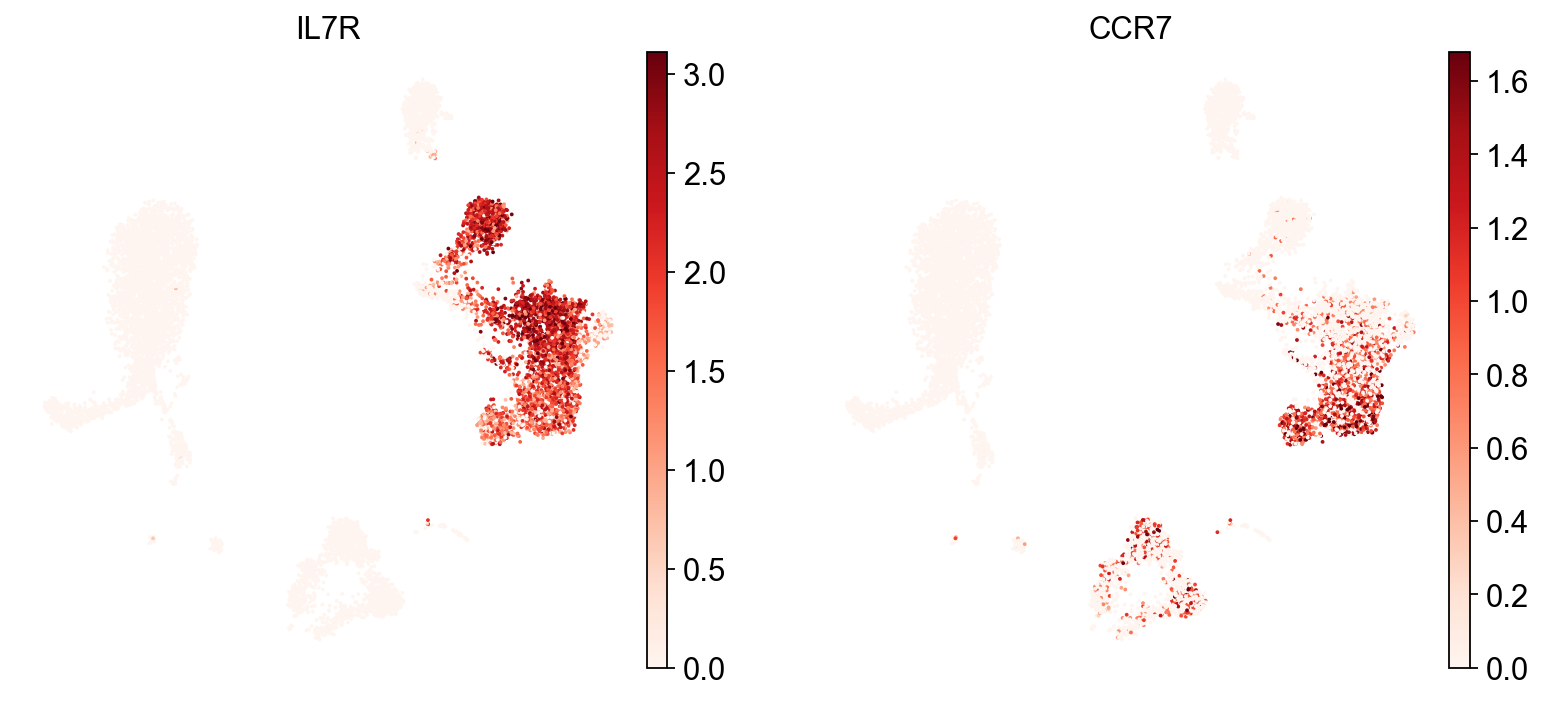





MEMORY CD4+:


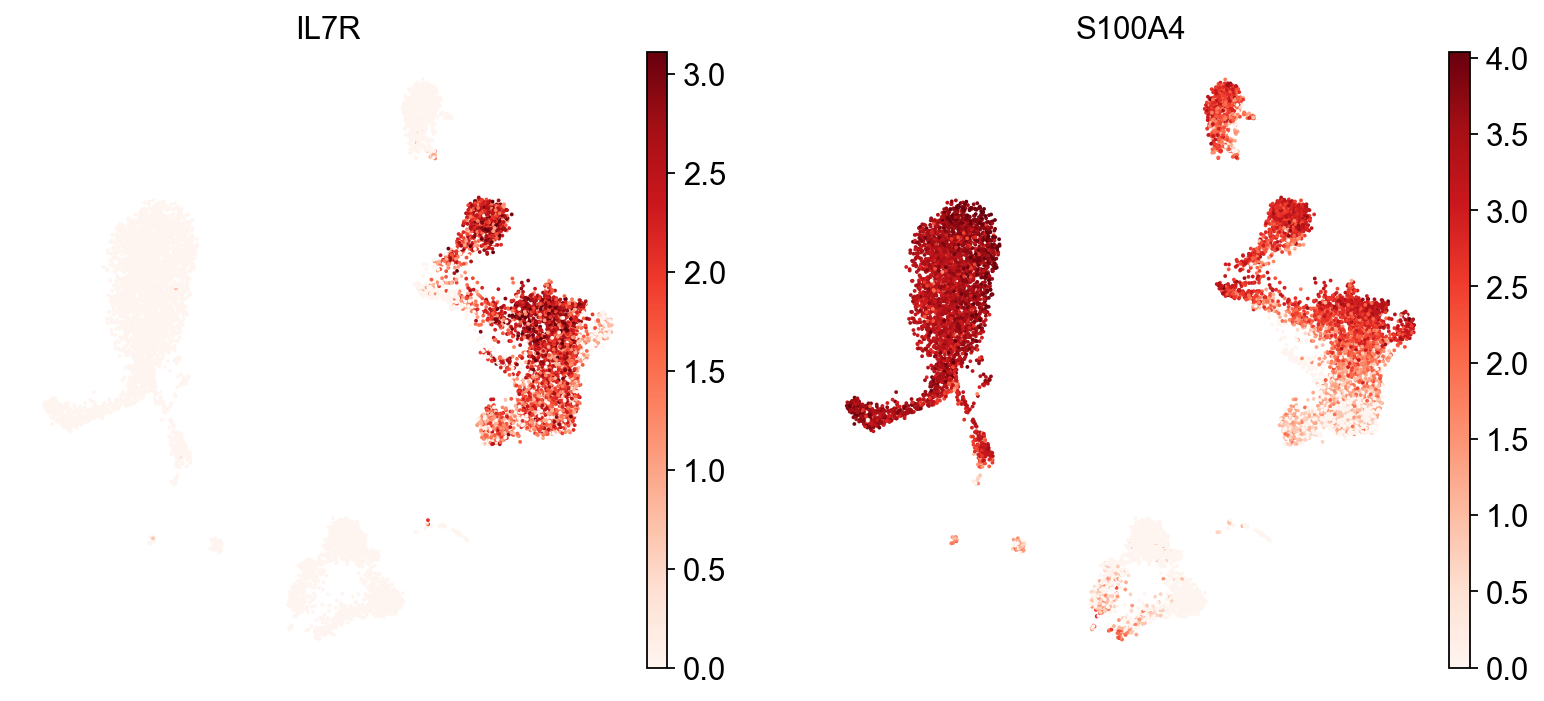





CD14+ MONO:


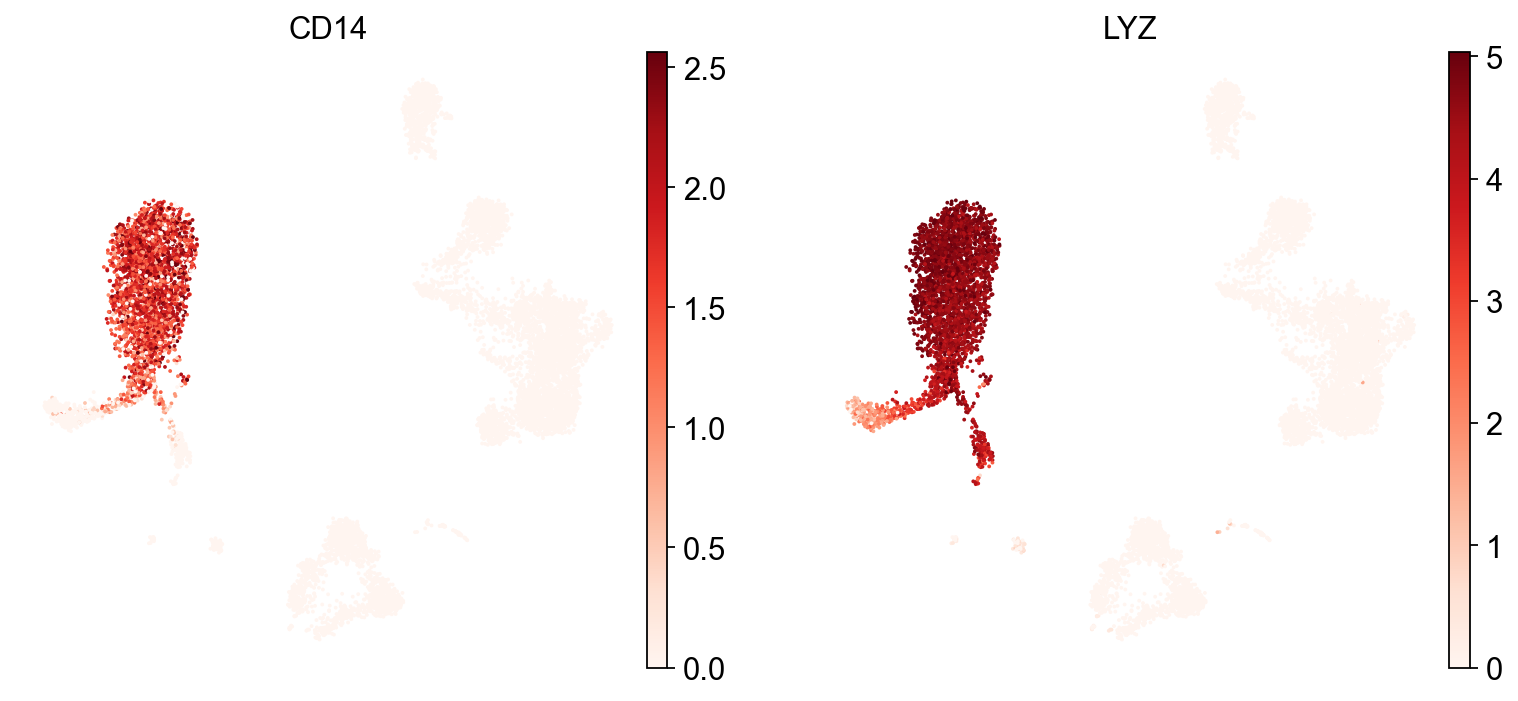





B:


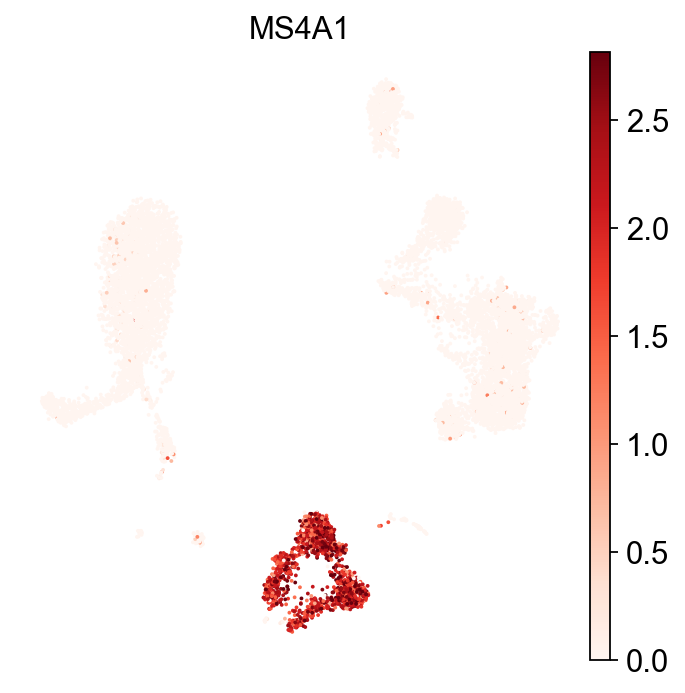





CD8+ T:


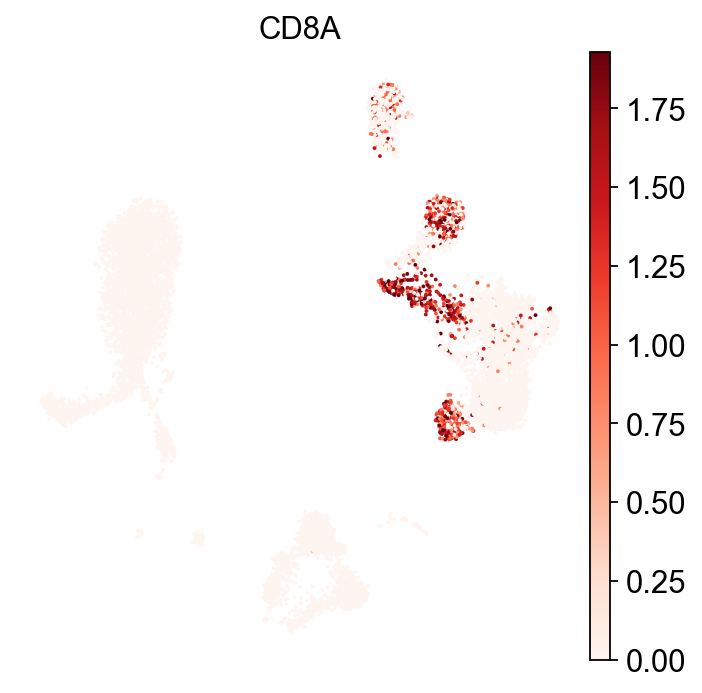





FCGR3A+ MONO:


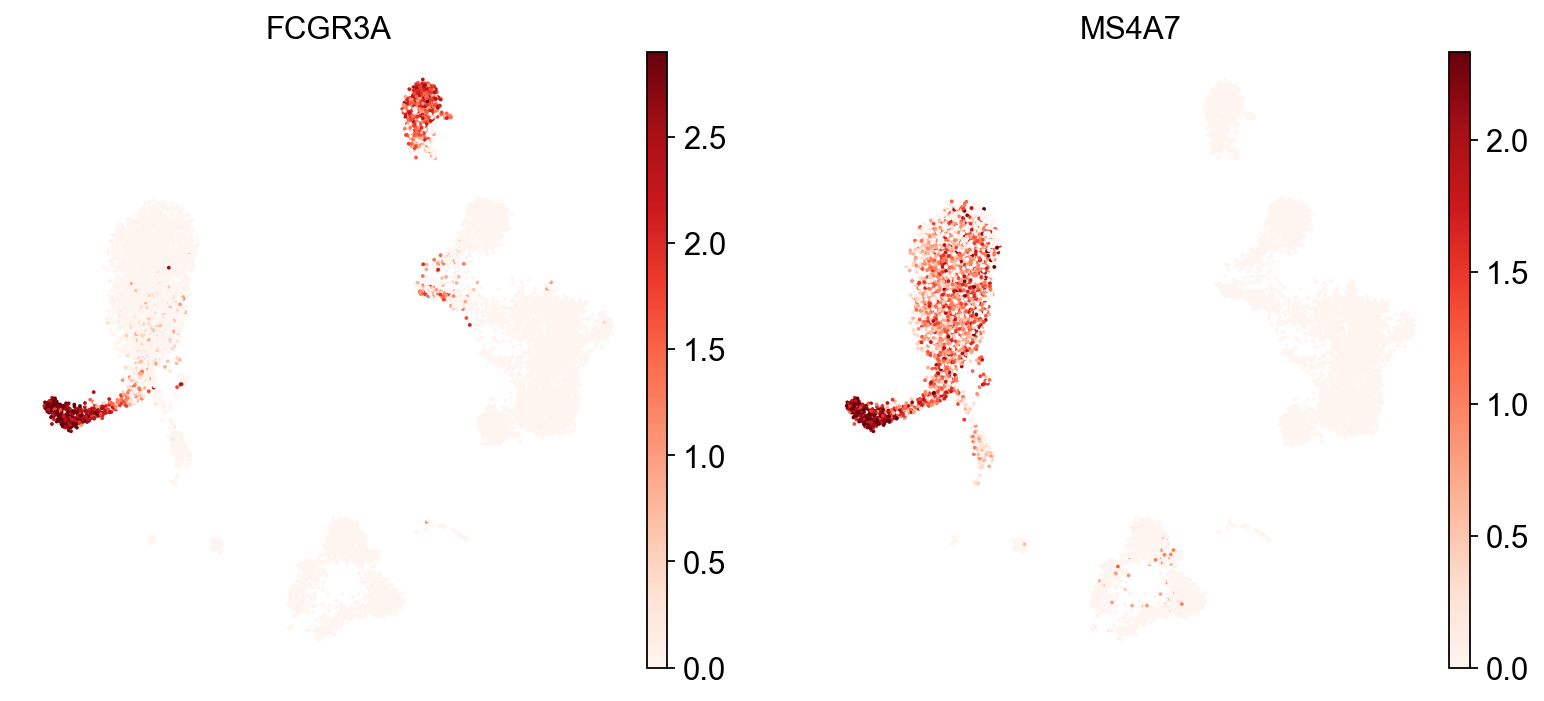





NK:


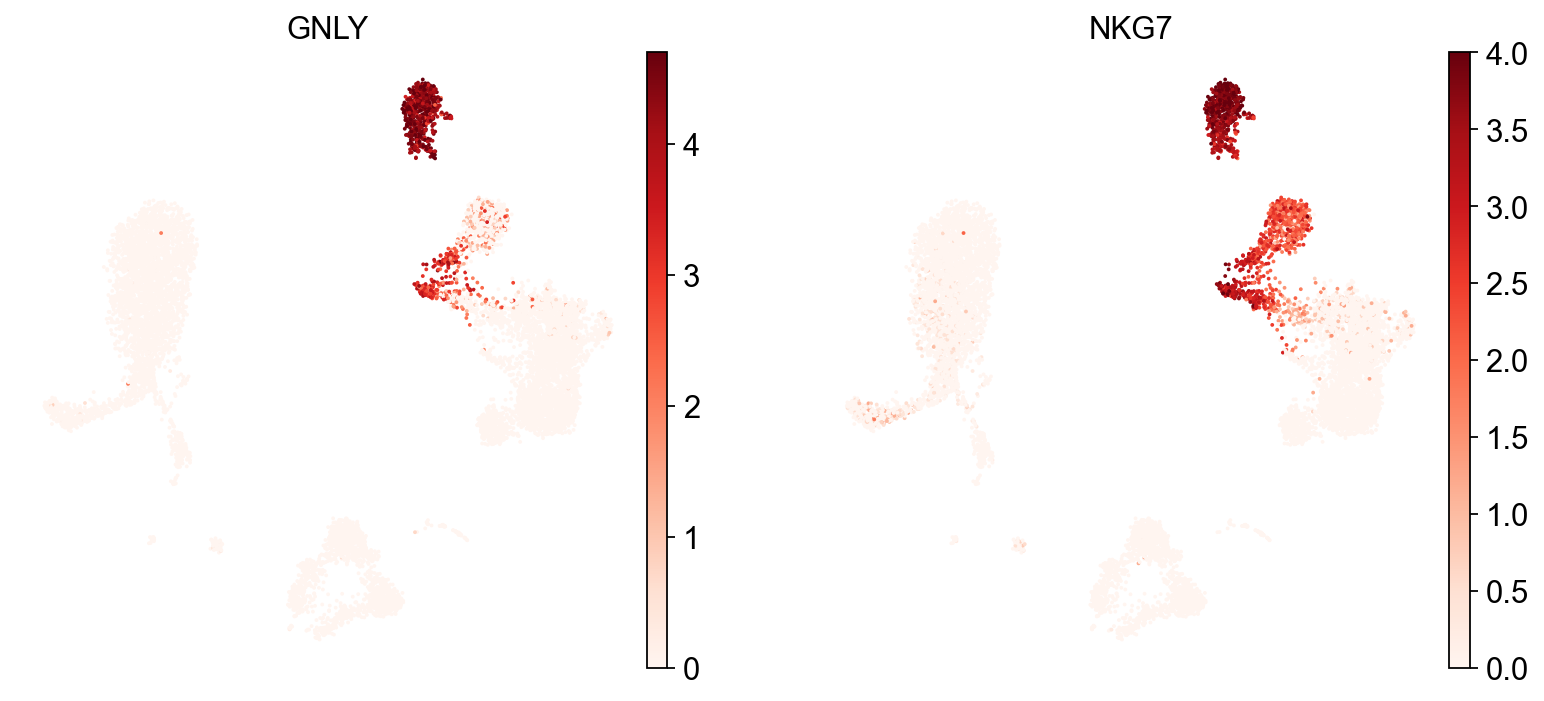





DC:


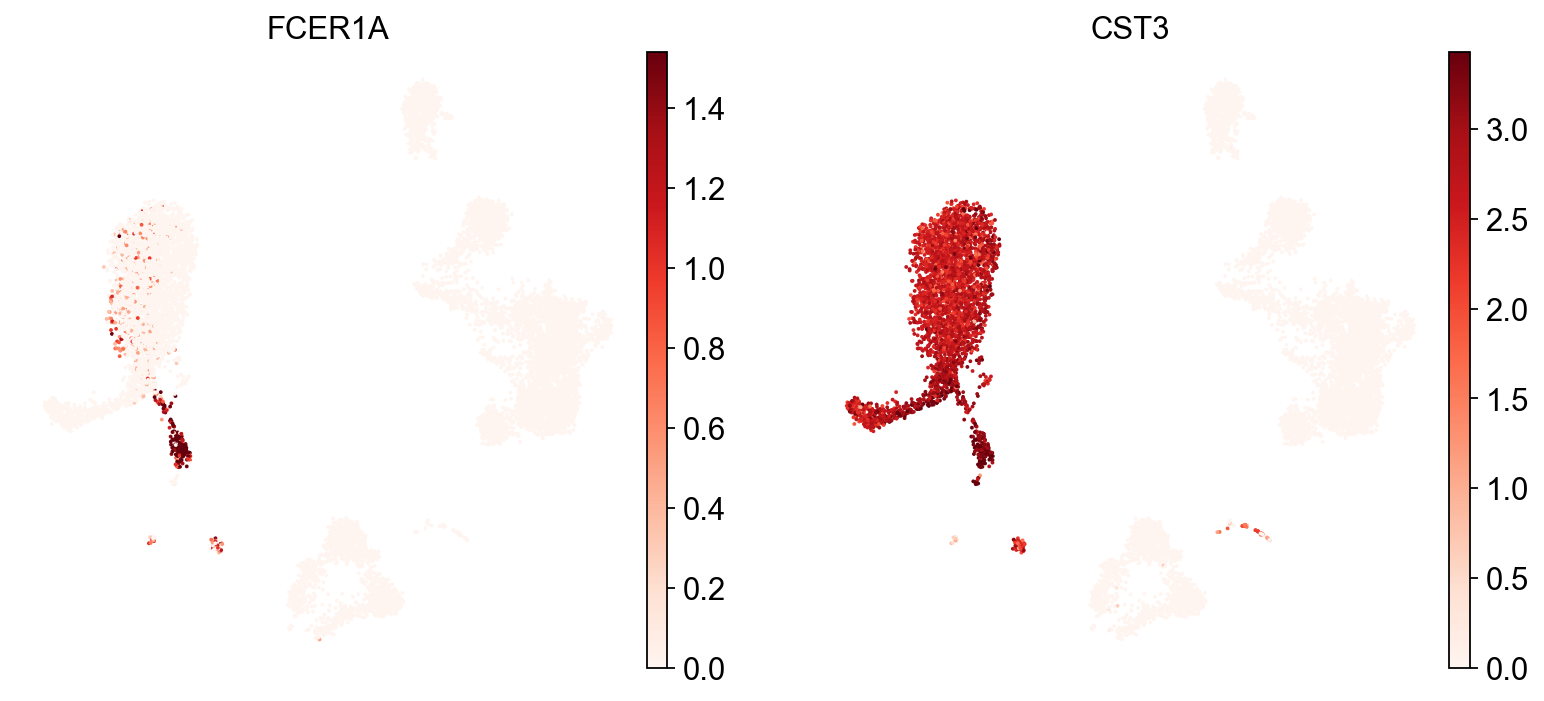





PLATELET:


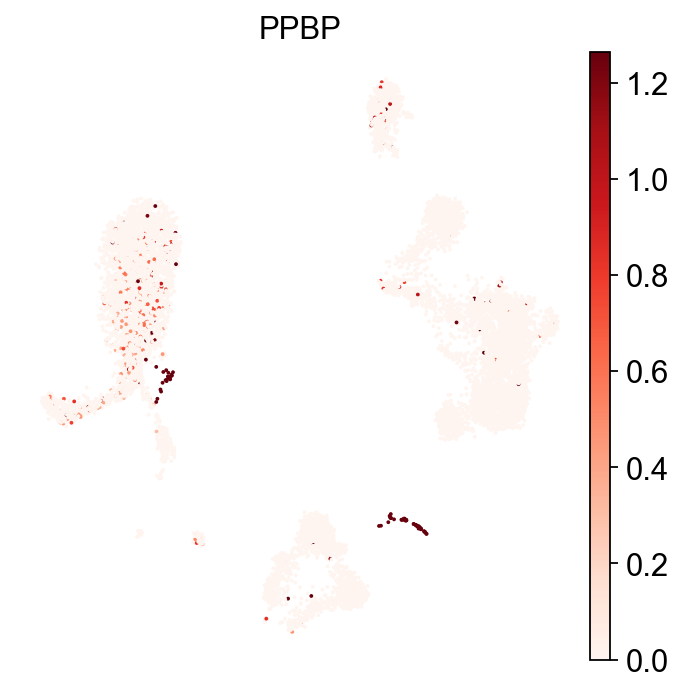

In [164]:
T_cells = [
    "Naive CD4+ T",
    "Memory CD4+",
    "CD14+ Mono",
    "B",
    "CD8+ T",
    "FCGR3A+ Mono",
    "NK",
    "DC",
    "Platelet",
]

for ct in T_cells:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        layer="log1p_norm",
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [165]:
# leiden resolution list
res_list = ['leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res1_5']

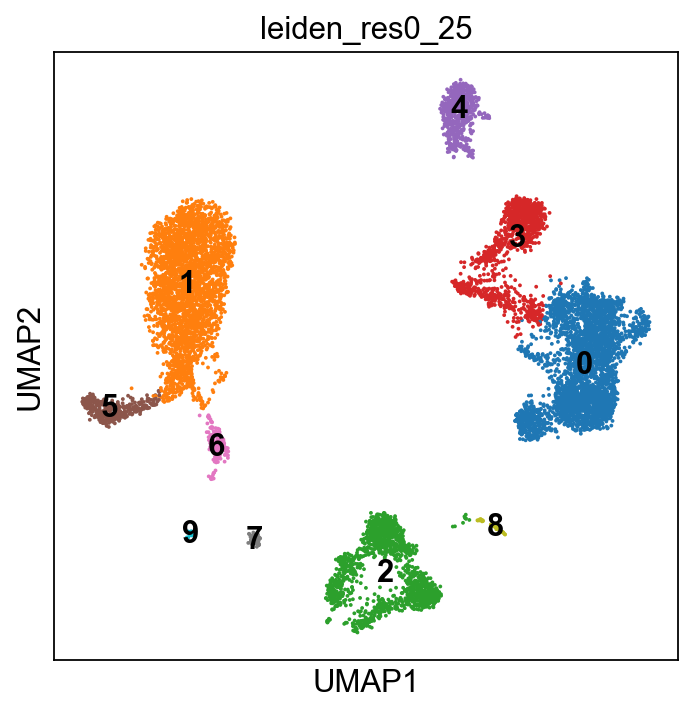

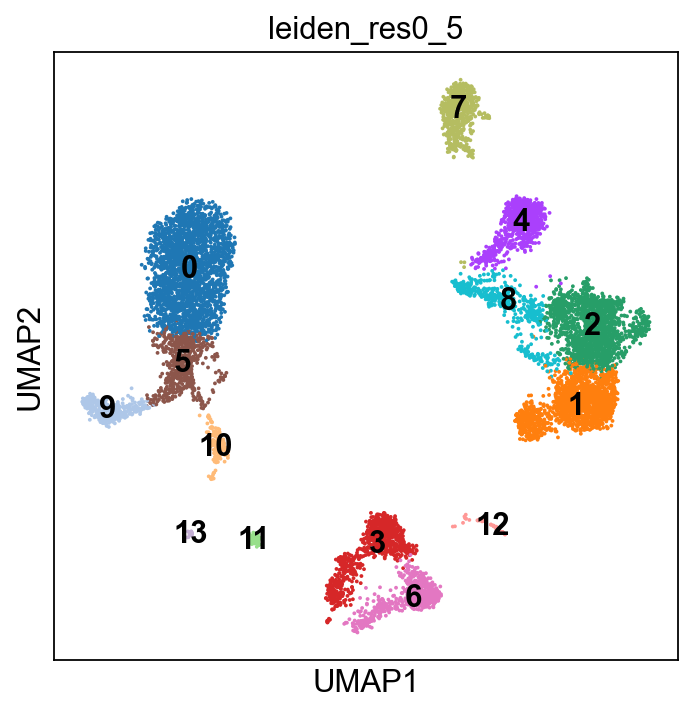

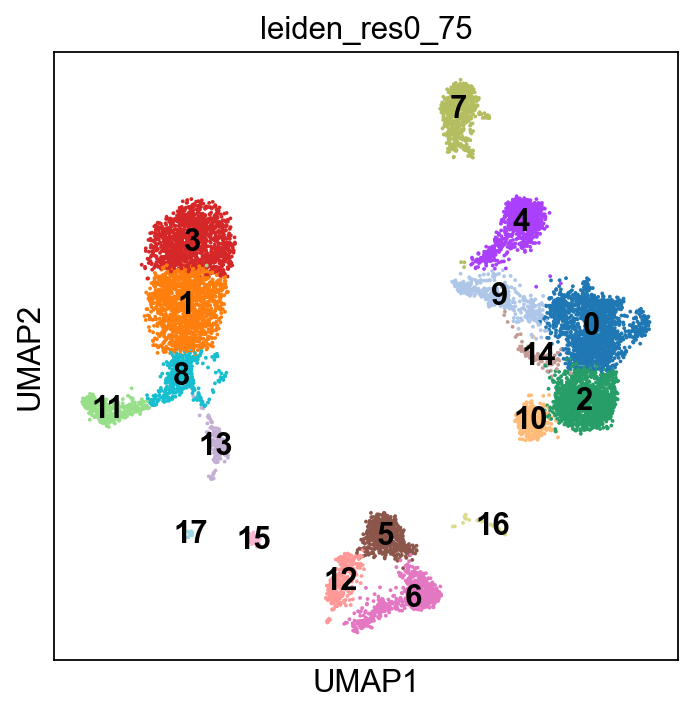

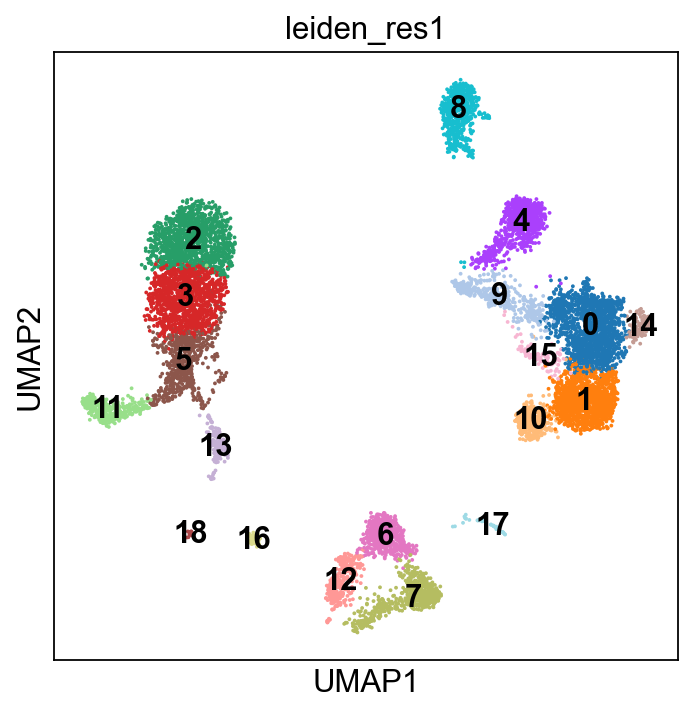

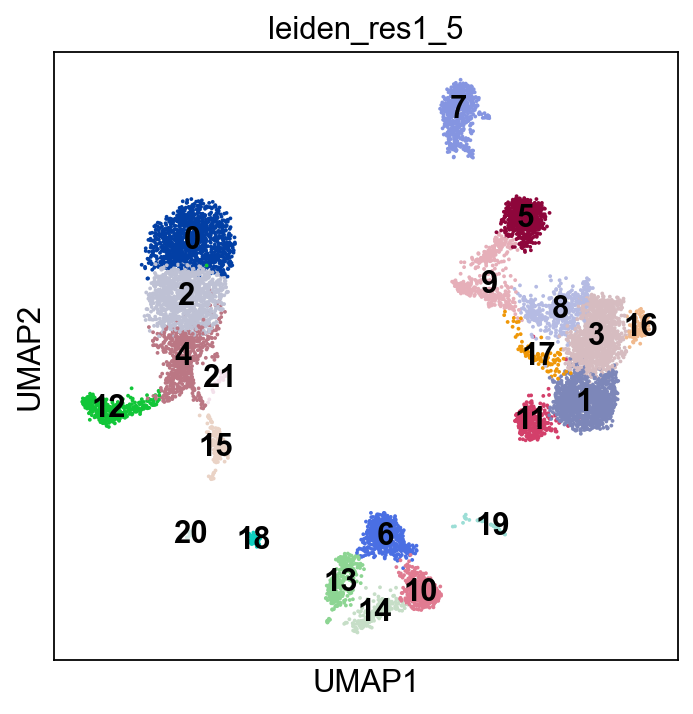

[None, None, None, None, None]

In [166]:
# UMAP
[
    sc.pl.umap(
        adata,
        #layer="log1p_norm",
        #todo, check if need to use layer, as color with leiden cluster, i think no need for this
        color=i,
        legend_loc="on data",
        save=f"umap_{i}.svg"
        )
        for i in res_list
    ]

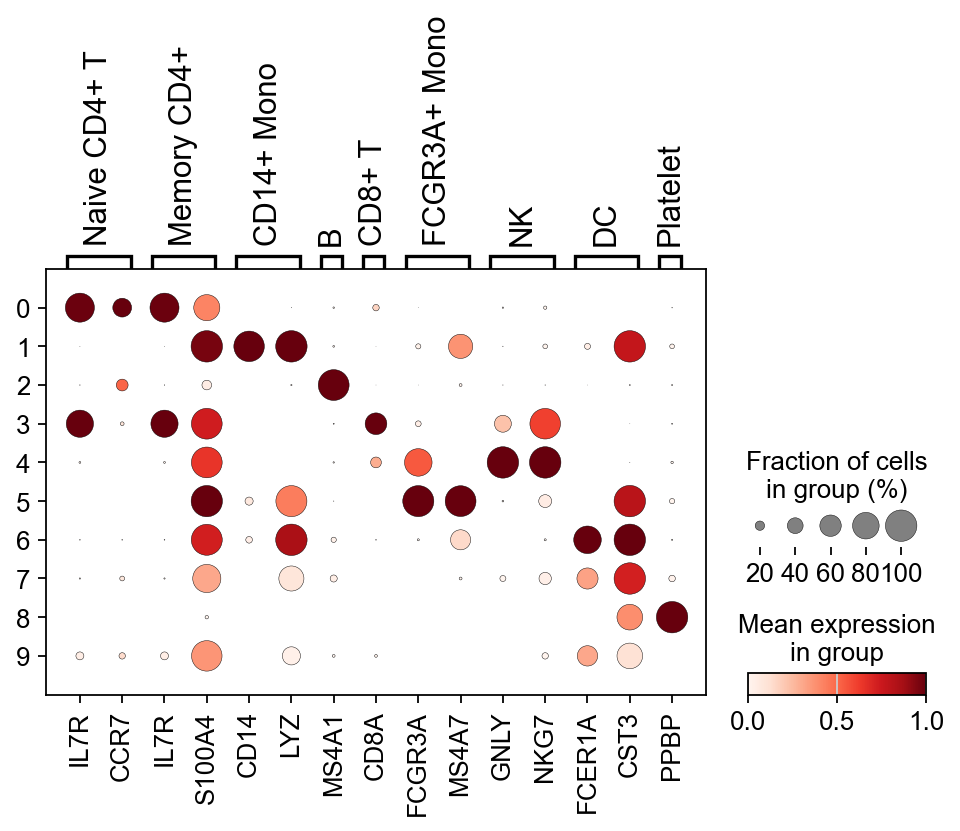

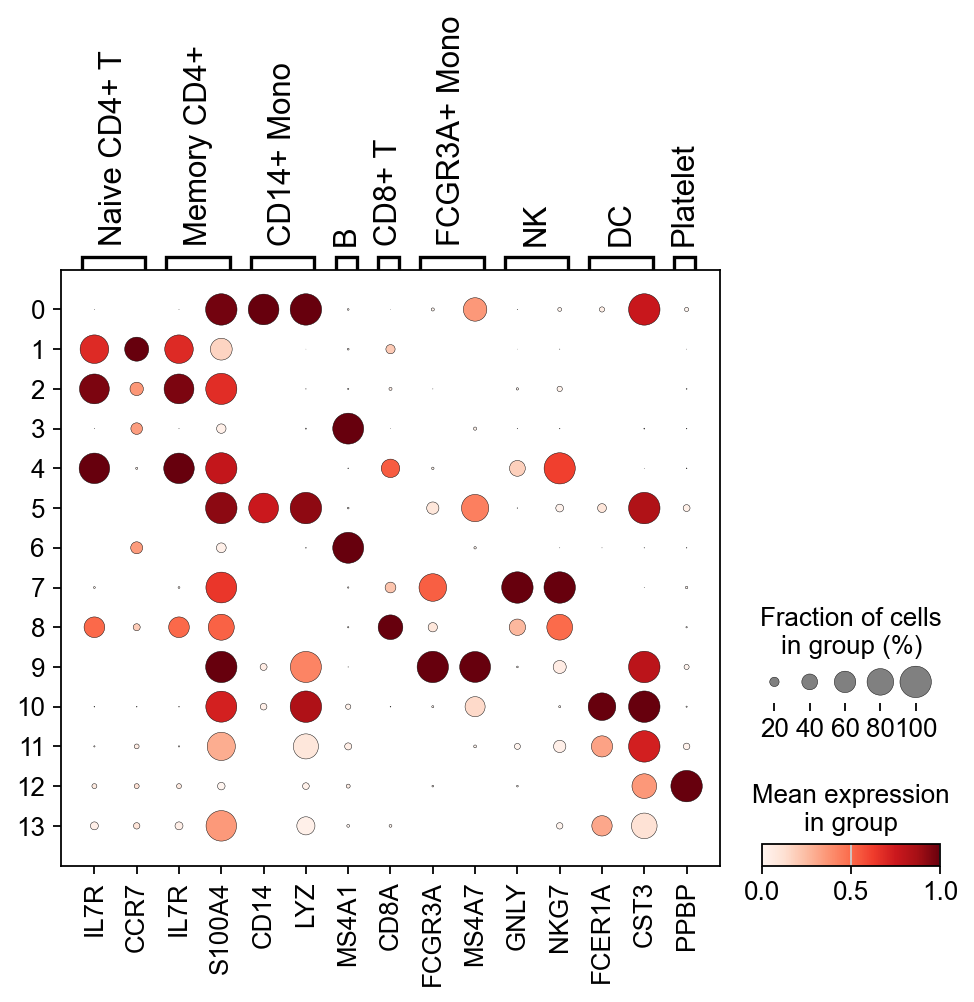

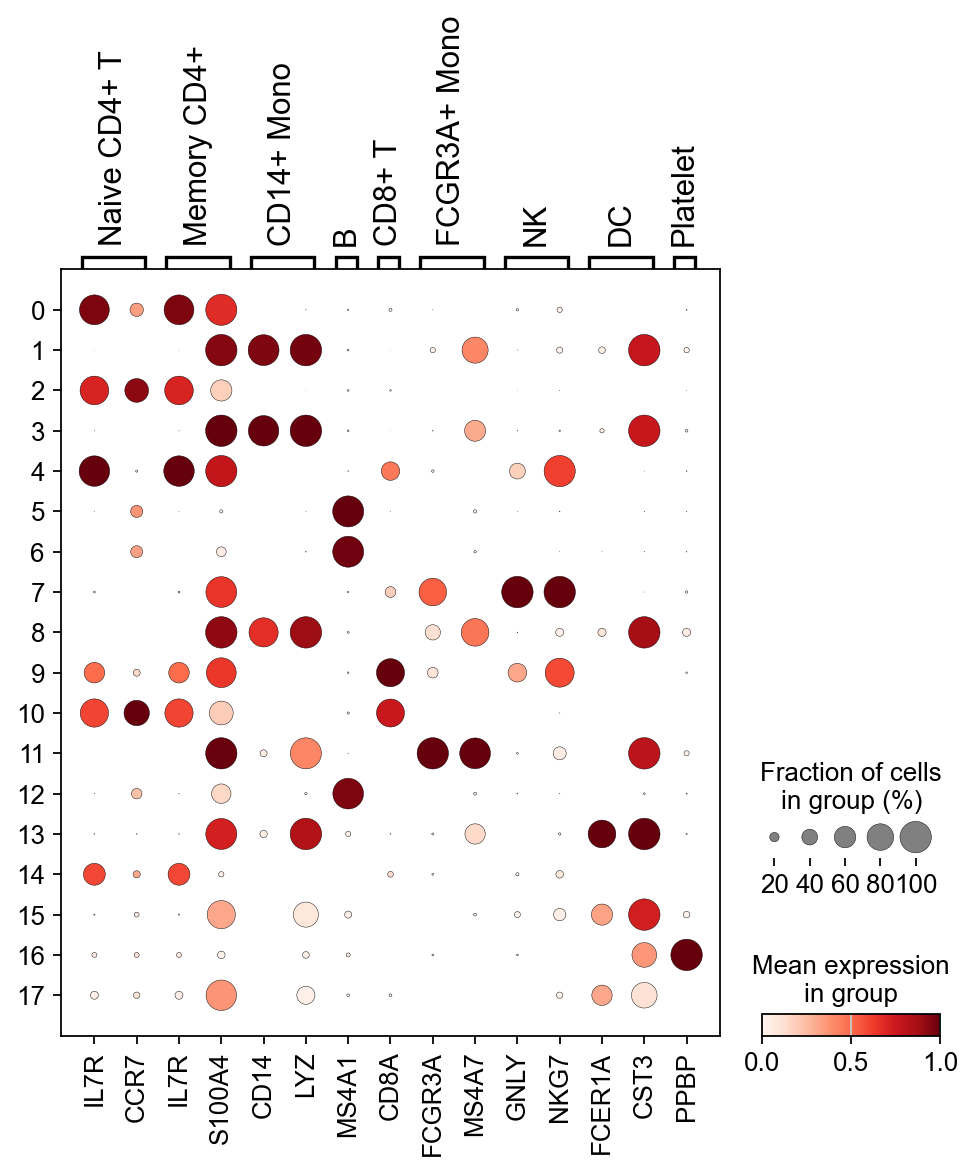

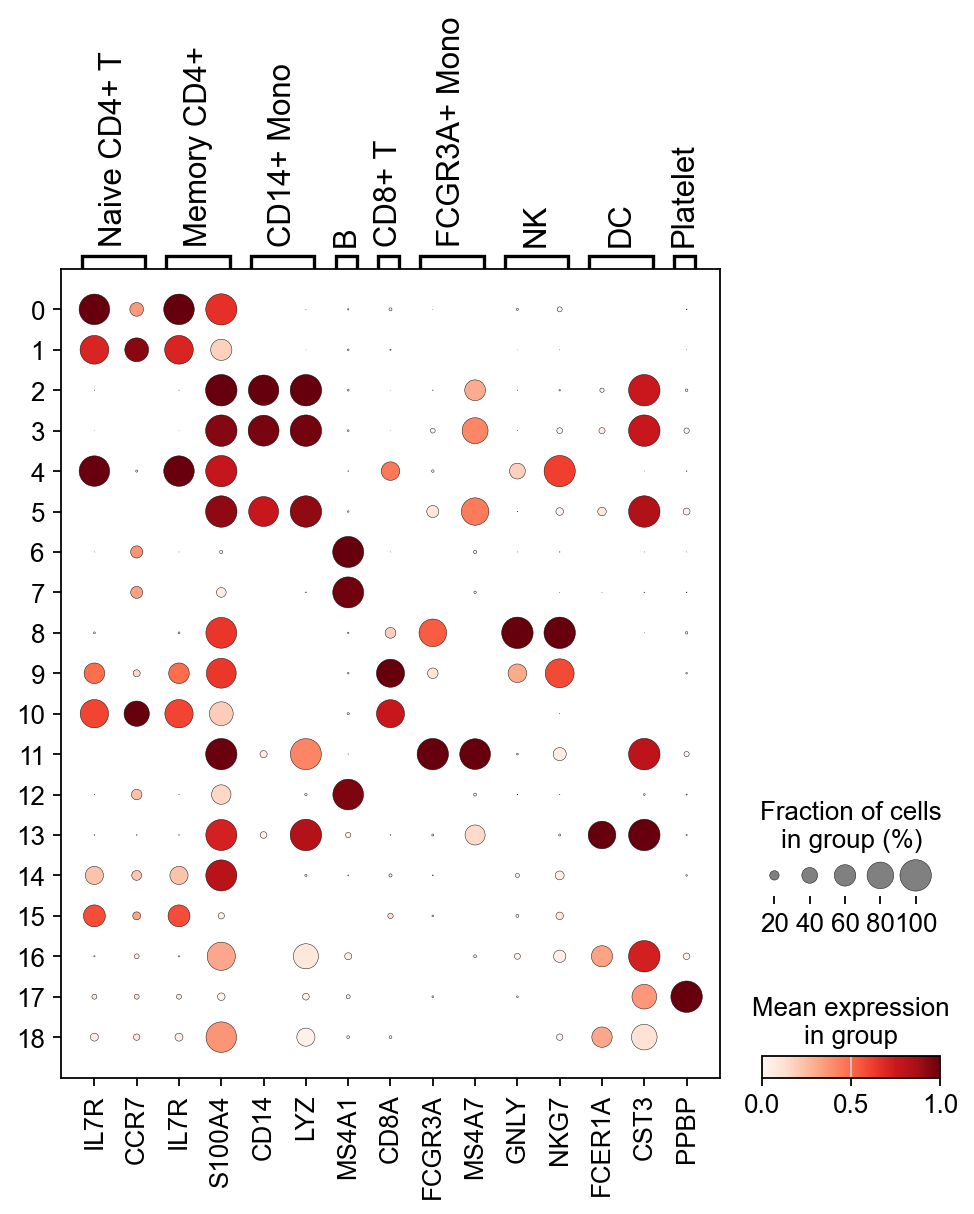

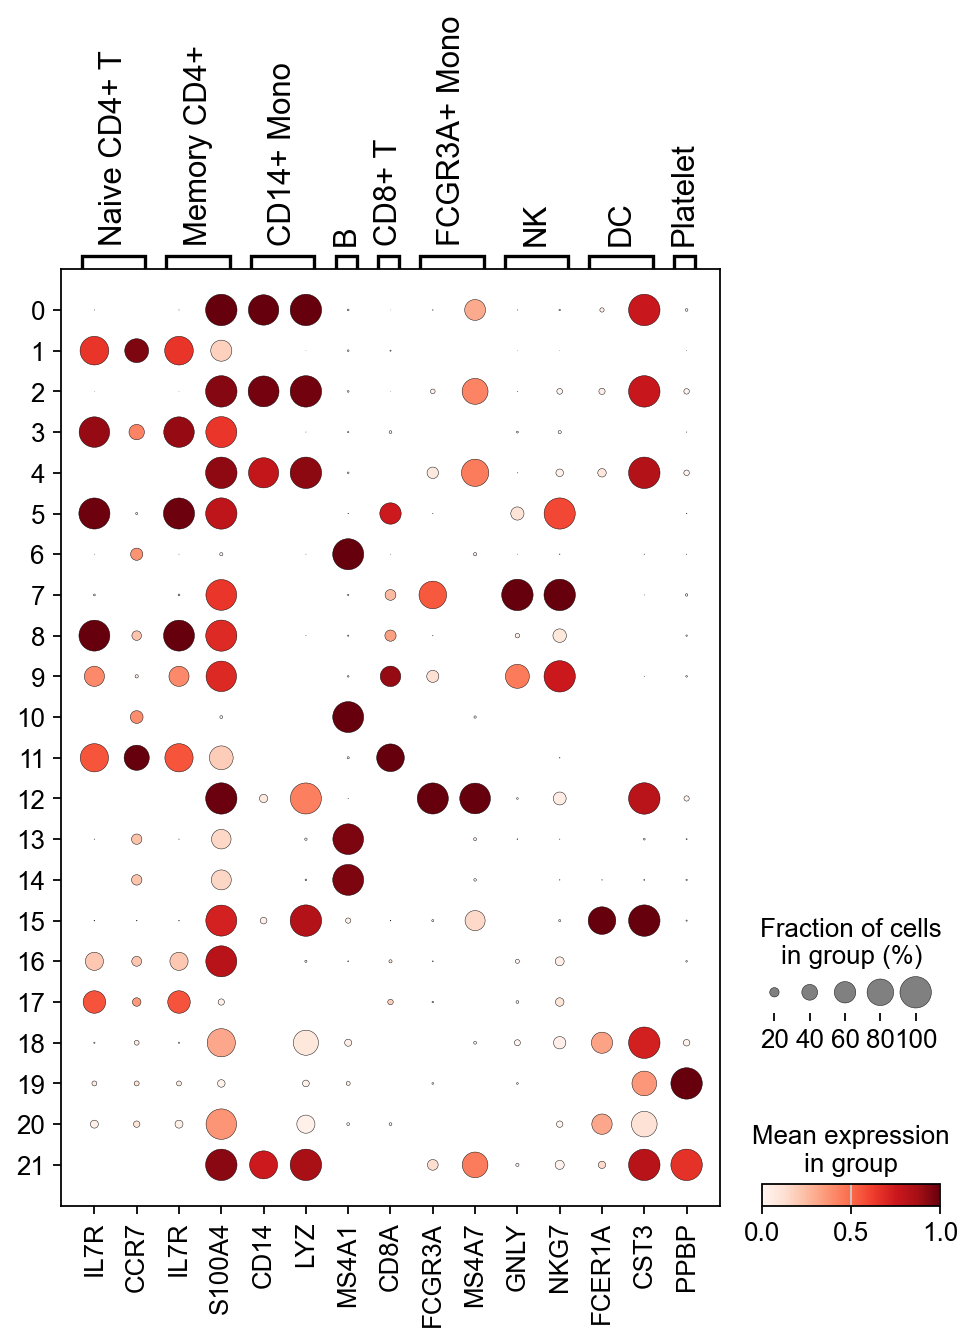

[None, None, None, None, None]

In [167]:
# dotplot
[
    sc.pl.dotplot(
        adata,
        use_raw=False,
        #layer="log1p_norm",
        #TODO: do not need to use layer,because is used the normalized data,check if it use adata.x (because i set it previously to normalized counts)
        groupby=i,
        var_names=marker_genes_in_data,
        standard_scale="var",
        save=f"dotplot_{i}.svg"
        )
        for i in res_list
    ]

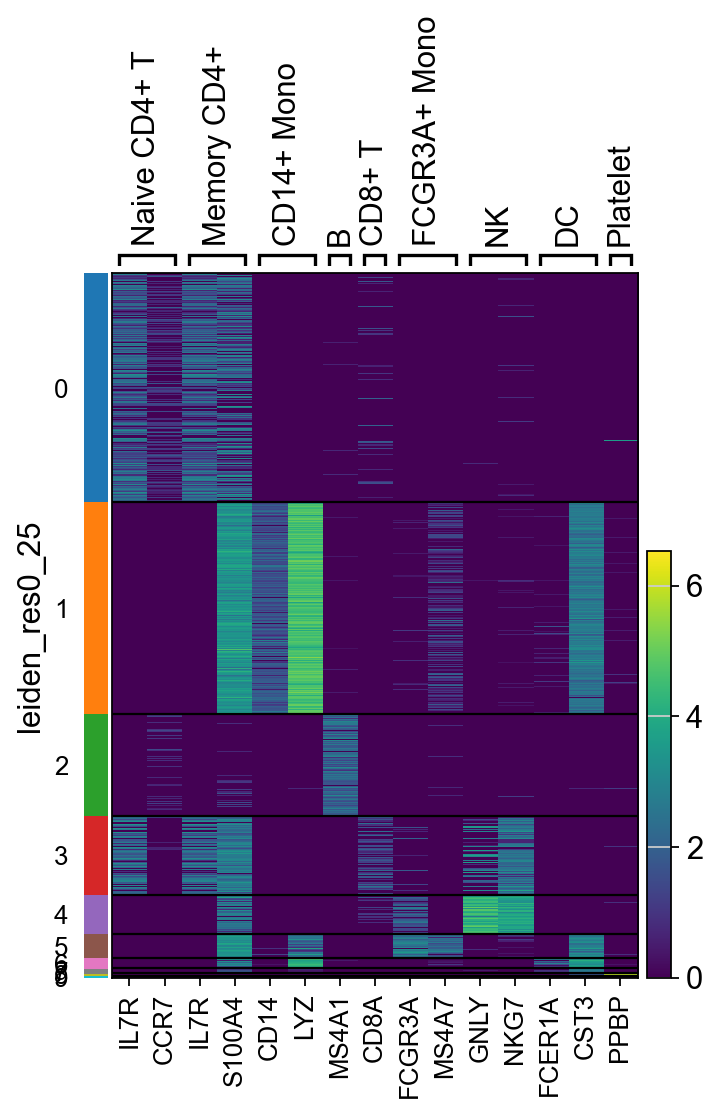

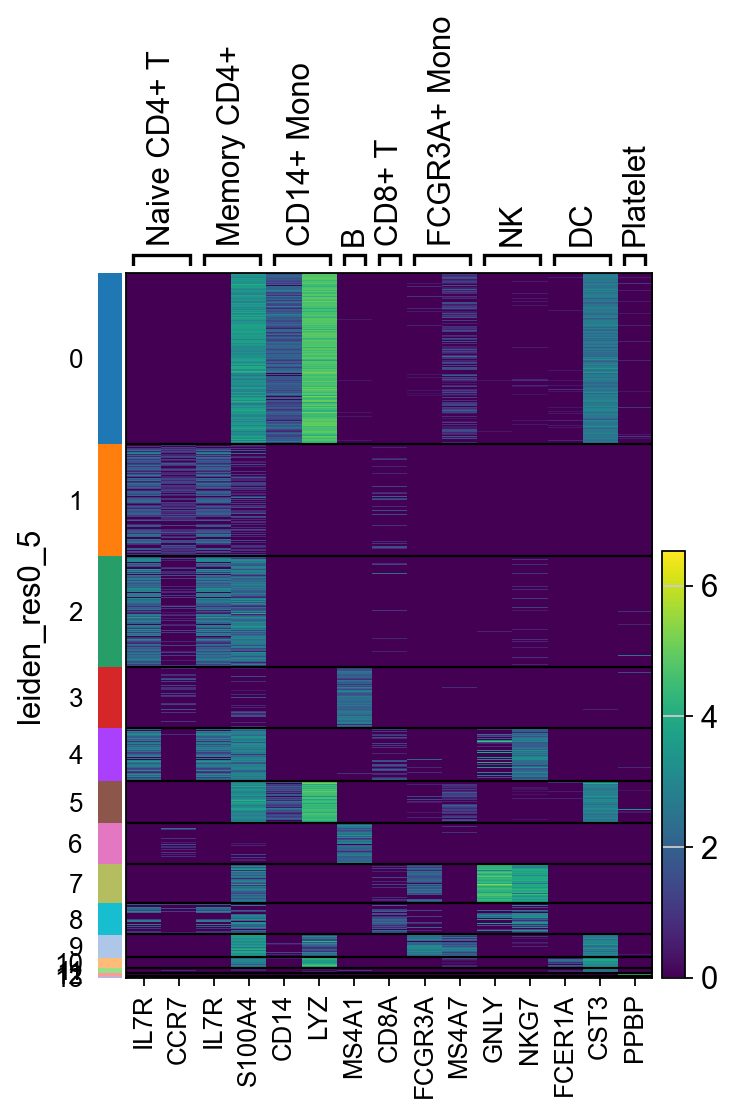

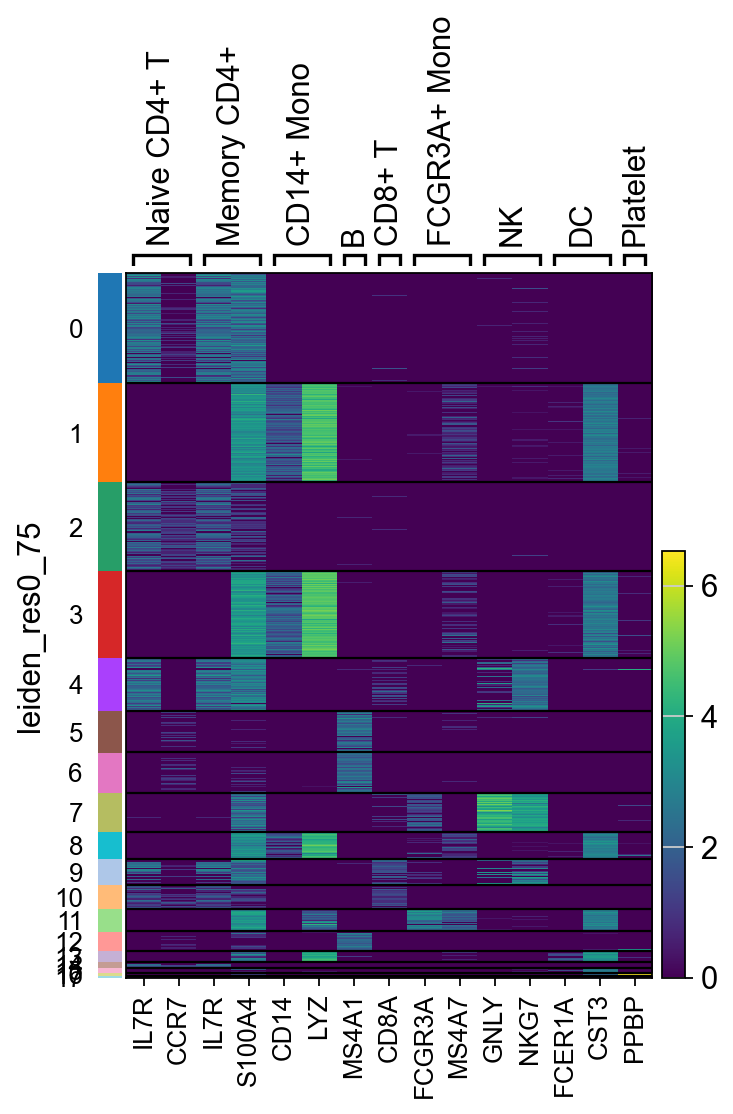

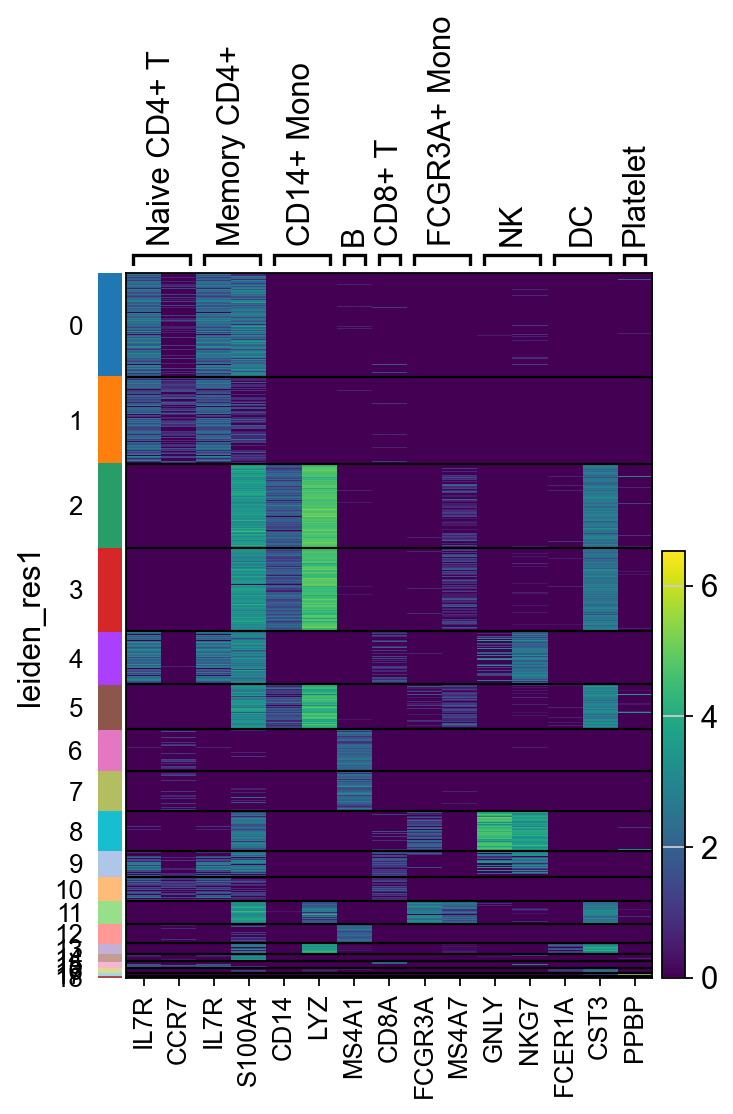

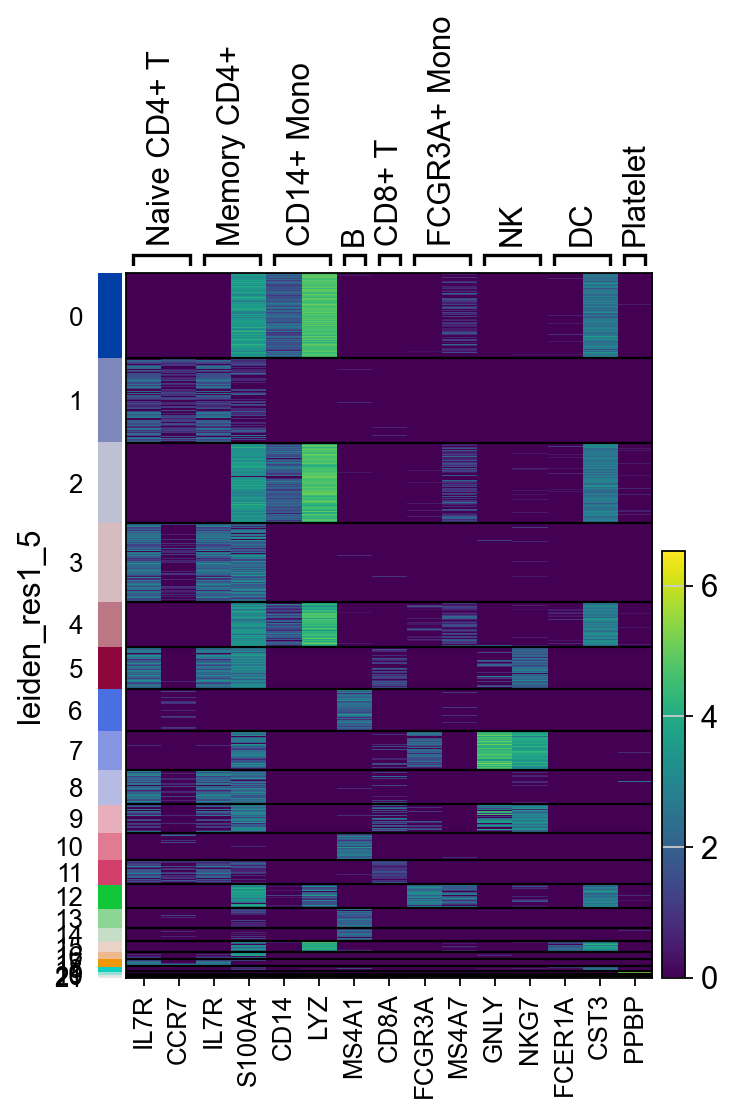

[None, None, None, None, None]

In [31]:
# heatmap
[
    sc.pl.heatmap(
        adata,
        use_raw=False,
        groupby=i,
        var_names=marker_genes_in_data,
        #save=f"heatmap_{i}.svg"
        )
        for i in res_list
    ]

In [170]:
# Using a combination of visual inspection of the UMAPs and the dotplot above we can now start annotating the clusters
cl_annotation = {
    "0": "Naive CD4+ T, Memory CD4+",
    "1": "CD14+ Mono",
    "2": "B",
    "3": "Naive CD4+ T, Memory CD4+, CD8+ T",
    "4": "NK",
    "5": "FCGR3A+ Mono, Memory CD4+(?)",
    "6": "DC",
    "7": "DC",
    "8": "Platelet",
}

In [172]:
adata.obs["manual_celltype_annotation_leiden_res0_25"] = adata.obs.leiden_res0_25.map(cl_annotation)

'\nAlix\'s code\nadata.obs["cell_type_annotation_marker_based"] = adata.obs["leiden_res1"].copy()\nadata.obs.replace(\n    {"cell_type_annotation_marker_based": cell_type_correspondance}, inplace=True\n)\n'

... storing 'manual_celltype_annotation_leiden_res0_25' as categorical


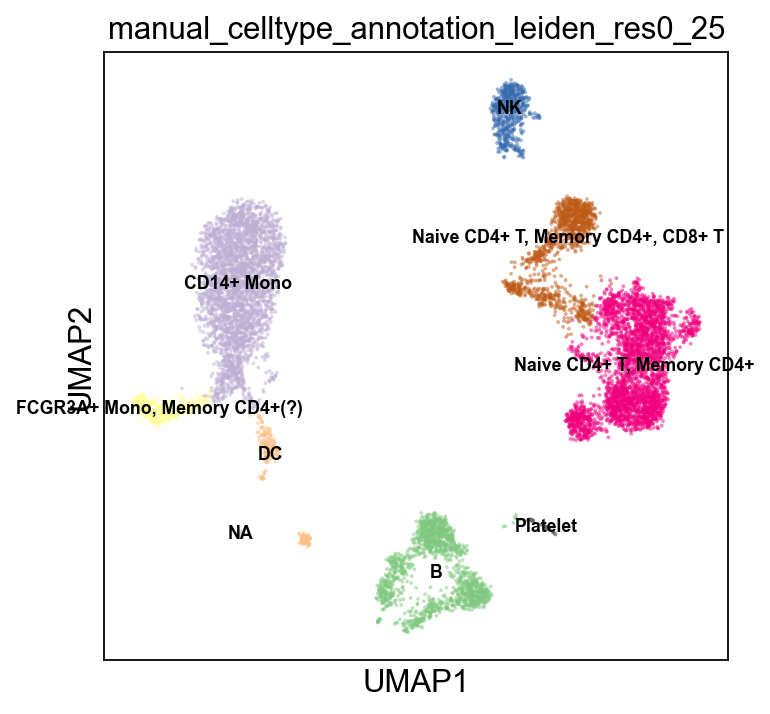

In [173]:
sc.pl.umap(
    adata,
    legend_loc="on data",
    legend_fontsize=8,
    alpha=0.5,
    color=["manual_celltype_annotation_leiden_res0_25"],
    palette="Accent",
)

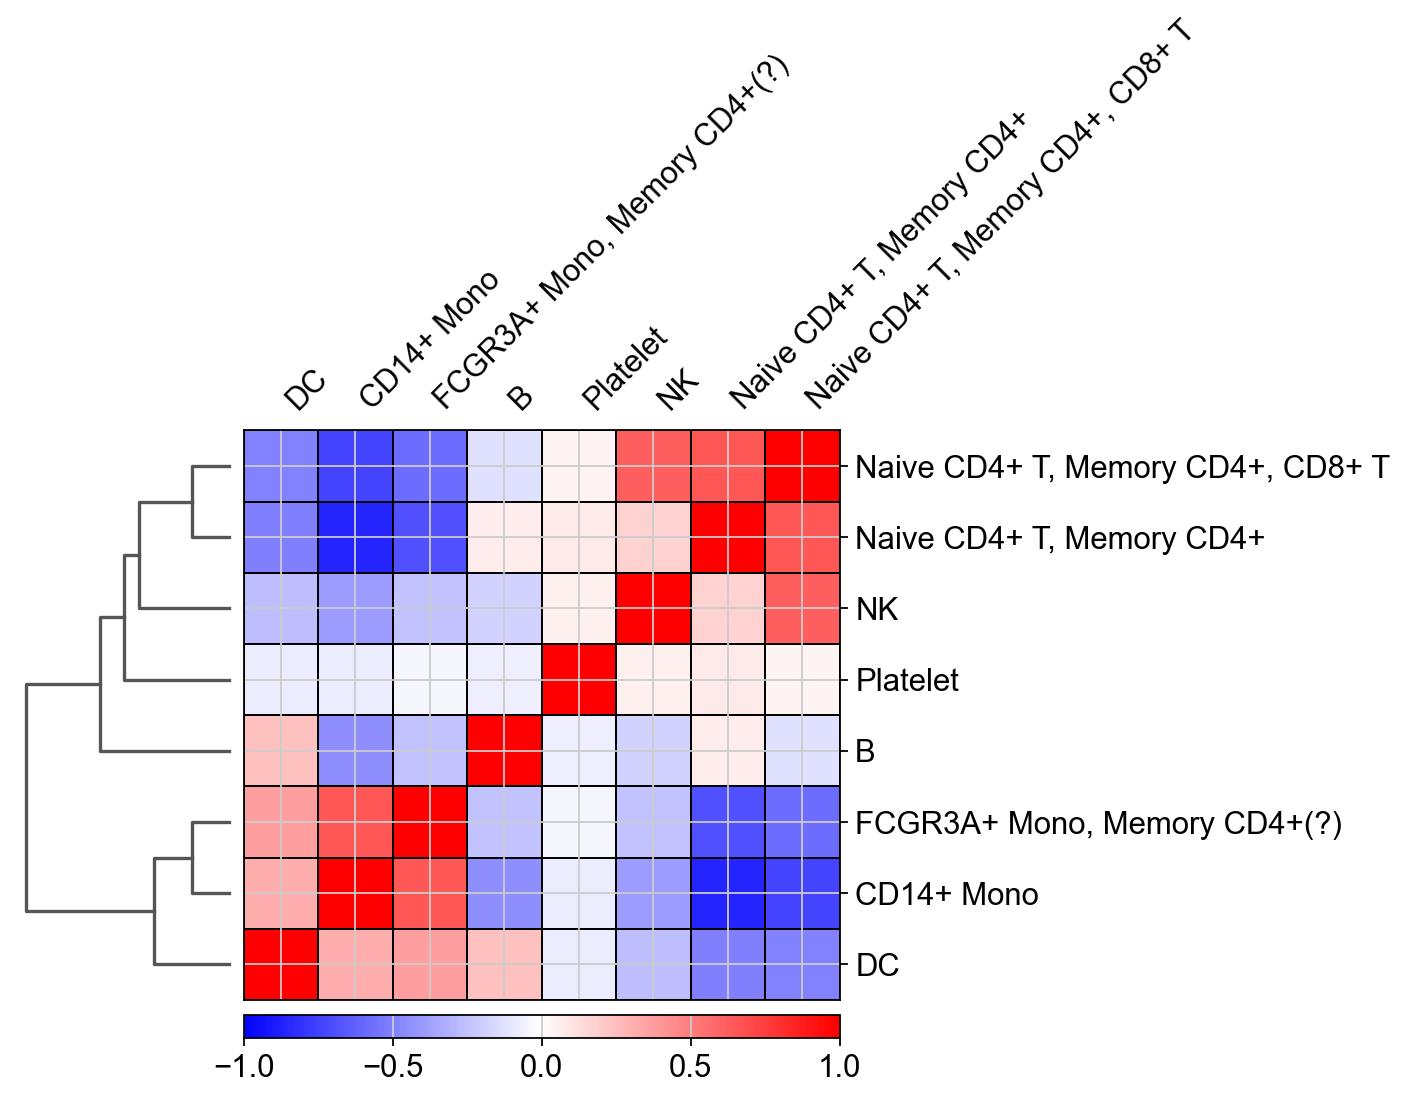

In [175]:
# correlation
sc.tl.dendrogram(adata, groupby="manual_celltype_annotation_leiden_res0_25", n_pcs=30)
sc.pl.correlation_matrix(
    adata,
    groupby="manual_celltype_annotation_leiden_res0_25",
    # save=f"correlation_matrix.svg"
)

### From cluster differentially expressed genes to cluster annotation

In [176]:
# calculate the DEG for every cluster, compared to the rest of the cells in our adata
# NB: p-value inflation phenomena
sc.tl.rank_genes_groups(
    adata,
    layer="log1p_norm",#todo: check, if use_raw=false, it will use adata.X
    use_raw=False, #by default None: Use raw attribute of adata if present
    groupby="leiden_res0_25",
    method="wilcoxon",
    key_added="dea_leiden_res0_25",
    pts=True,
)

In [177]:
adata.uns["dea_leiden_res0_25"]

{'params': {'groupby': 'leiden_res0_25',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': 'log1p_norm',
  'corr_method': 'benjamini-hochberg'},
 'pts':                     0         1         2         3    4         5         6  \
 DDX11L1      0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 WASH7P       0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 MIR6859-1    0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 MIR1302-2HG  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 MIR1302-2    0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 ...               ...       ...       ...       ...  ...       ...       ...   
 AC007325.1   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
 AC007325.4   0.015682  0.037773  0.002705  0.009607  0.0  0.057637  0.033113   
 AC007325.2   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.006623   
 U6-36    

In [179]:
# output the DEG results to csv
result = adata.uns["dea_leiden_res0_25"]
display(result.keys())

groups = result["names"].dtype.names
display(groups)

res = pd.DataFrame(
    {
        group + "_" + key: result[key][group]
        for group in groups
        for key in ["names", "pts", "logfoldchanges", "pvals_adj", "scores"]
    }
)
res
# res.to_csv("dif.csv")

dict_keys(['params', 'pts', 'pts_rest', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

0_names     0_pts  0_logfoldchanges  0_pvals_adj   0_scores  \
DDX11L1         LDHB  0.000000          2.738255          0.0  71.434944   
WASH7P         RPS12  0.000000          1.264398          0.0  66.711540   
MIR6859-1     RPS15A  0.000000          1.004414          0.0  66.331413   
MIR1302-2HG    RPS29  0.000000          1.506543          0.0  66.114059   
MIR1302-2       TPT1  0.000000          0.763417          0.0  65.991966   
...              ...       ...               ...          ...        ...   
AC007325.1      OAZ1  0.000000         -1.567980          0.0 -59.858551   
AC007325.4     ARPC3  0.015682         -1.507327          0.0 -59.975132   
AC007325.2   HLA-DRA  0.000000        -10.074876          0.0 -60.331039   
U6-36           CD74  0.000000         -5.069117          0.0 -65.571037   
U1-15           CYBA  0.000000         -1.950901          0.0 -68.446960   

            1_names     1_pts  1_logfoldchanges  1_pvals_adj   1_scores  ...  \
DDX11L1      S100A8  0.000000         10.515011          0.0  80.166748  ...   
WASH7P       S100A9  0.000000          9.965269          0.0  80.104927  ...   
MIR6859-1       LYZ  0.000000          8.867542          0.0  79.874313  ...   
MIR1302-2HG    MNDA  0.000000          6.774597          0.0  79.268341  ...   
MIR1302-2      VCAN  0.000000          8.899281          0.0  79.192612  ...   
...             ...       ...               ...          ...        ...  ...   
AC007325.1   RPL23A  0.000000         -1.609960          0.0 -71.302818  ...   
AC007325.4     RPSA  0.037773         -2.292443          0.0 -73.263763  ...   
AC007325.2    RPS29  0.000000         -2.079803          0.0 -75.123413  ...   
U6-36         RPS27  0.000000         -1.890605          0.0 -75.160431  ...   
U1-15         RPS19  0.000000         -1.701797          0.0 -75.965988  ...   

            8_names     8_pts  8_logfoldchanges   8_pvals_adj   8_scores  \
DDX11L1        ODC1  0.000000          6.916923  2.032176e-23  10.656676   
WASH7P          GP9  0.000000         12.422117  2.032176e-23  10.656622   
MIR6859-1      GPX1  0.000000          5.911174  2.032176e-23  10.656567   
MIR1302-2HG   CMTM5  0.000000         11.813547  2.032176e-23  10.656511   
MIR1302-2    TAGLN2  0.000000          4.971991  2.032176e-23  10.656456   
...             ...       ...               ...           ...        ...   
AC007325.1    RPL32  0.000000        -11.048298  2.032176e-23 -10.649153   
AC007325.4     RPS2  0.026316        -34.621941  2.032176e-23 -10.649346   
AC007325.2    RPL28  0.000000         -9.029638  2.032176e-23 -10.652157   
U6-36         RPL13  0.000000         -8.143671  2.032176e-23 -10.654086   
U1-15        EEF1A1  0.000000         -7.963977  2.032176e-23 -10.654885   

                 9_names  9_pts  9_logfoldchanges   9_pvals_adj  9_scores  
DDX11L1           PRSS57   0.00          9.249623  3.652468e-13  8.627698  
WASH7P              SOX4   0.00          5.079918  1.168967e-12  8.365021  
MIR6859-1           CD34   0.00         11.881057  1.443986e-12  8.300642  
MIR1302-2HG  LRRC75A-AS1   0.00          2.621237  1.443986e-12  8.279454  
MIR1302-2           CDK6   0.00          5.130937  4.030781e-12  8.099322  
...                  ...    ...               ...           ...       ...  
AC007325.1        TMSB10   0.00         -1.501472  1.037437e-11 -7.944113  
AC007325.4           B2M   0.04         -2.014400  7.470322e-12 -8.009442  
AC007325.2        TMSB4X   0.00         -2.421445  2.689264e-12 -8.164550  
U6-36              HLA-C   0.00         -2.109961  2.517834e-12 -8.191069  
U1-15              HLA-B   0.00         -1.925058  1.168967e-12 -8.403662  

[58347 rows x 50 columns]

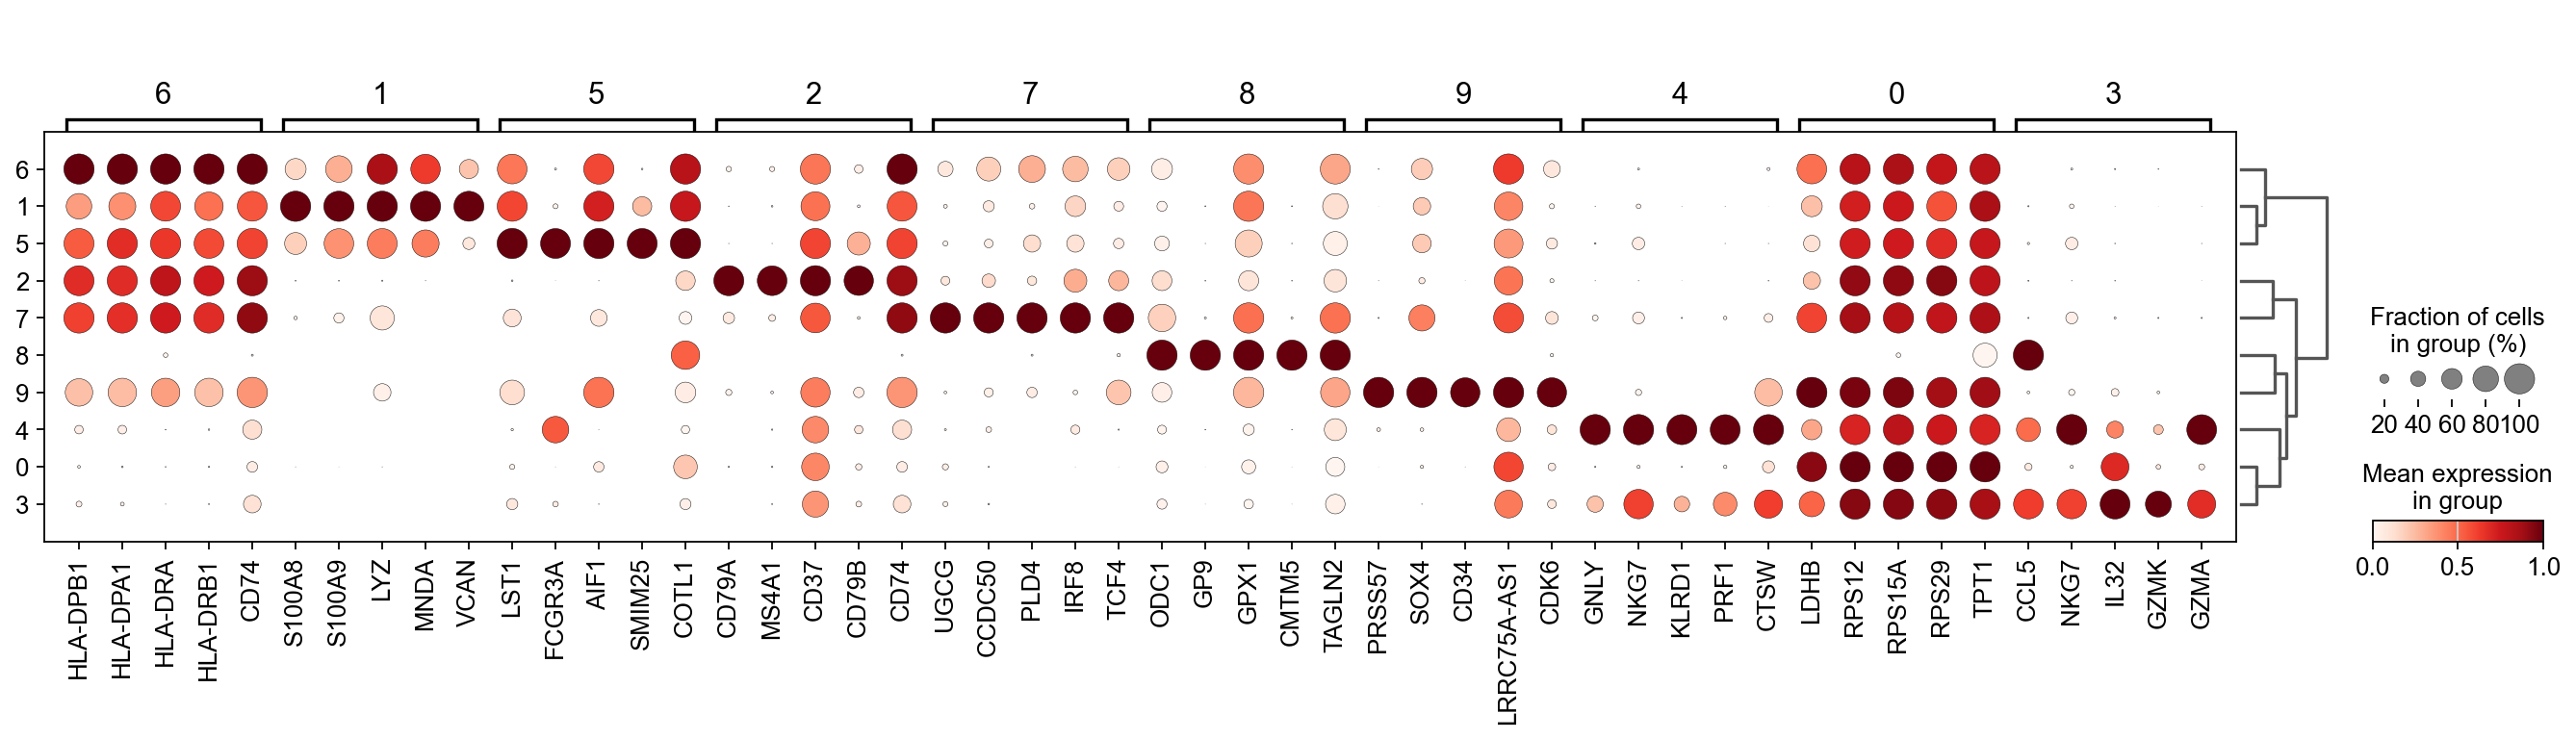

In [180]:
# visualize expression of the top DEG per cluster
sc.pl.rank_genes_groups_dotplot(
    adata,
    layer="log1p_norm",
    groupby="leiden_res0_25",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_res0_25"
)

###### As a lot (or some) of the DEG are highly expressed in multiple clusters. We can filter the DEG to select for more cluster-specific DEG

In [181]:
# DEA filtering
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    min_fold_change=1, # should be the log2fc, because is pl step, it gives the log2fc results
    key="dea_leiden_res0_25",
    key_added="dea_leiden_res0_25_filtered",
)

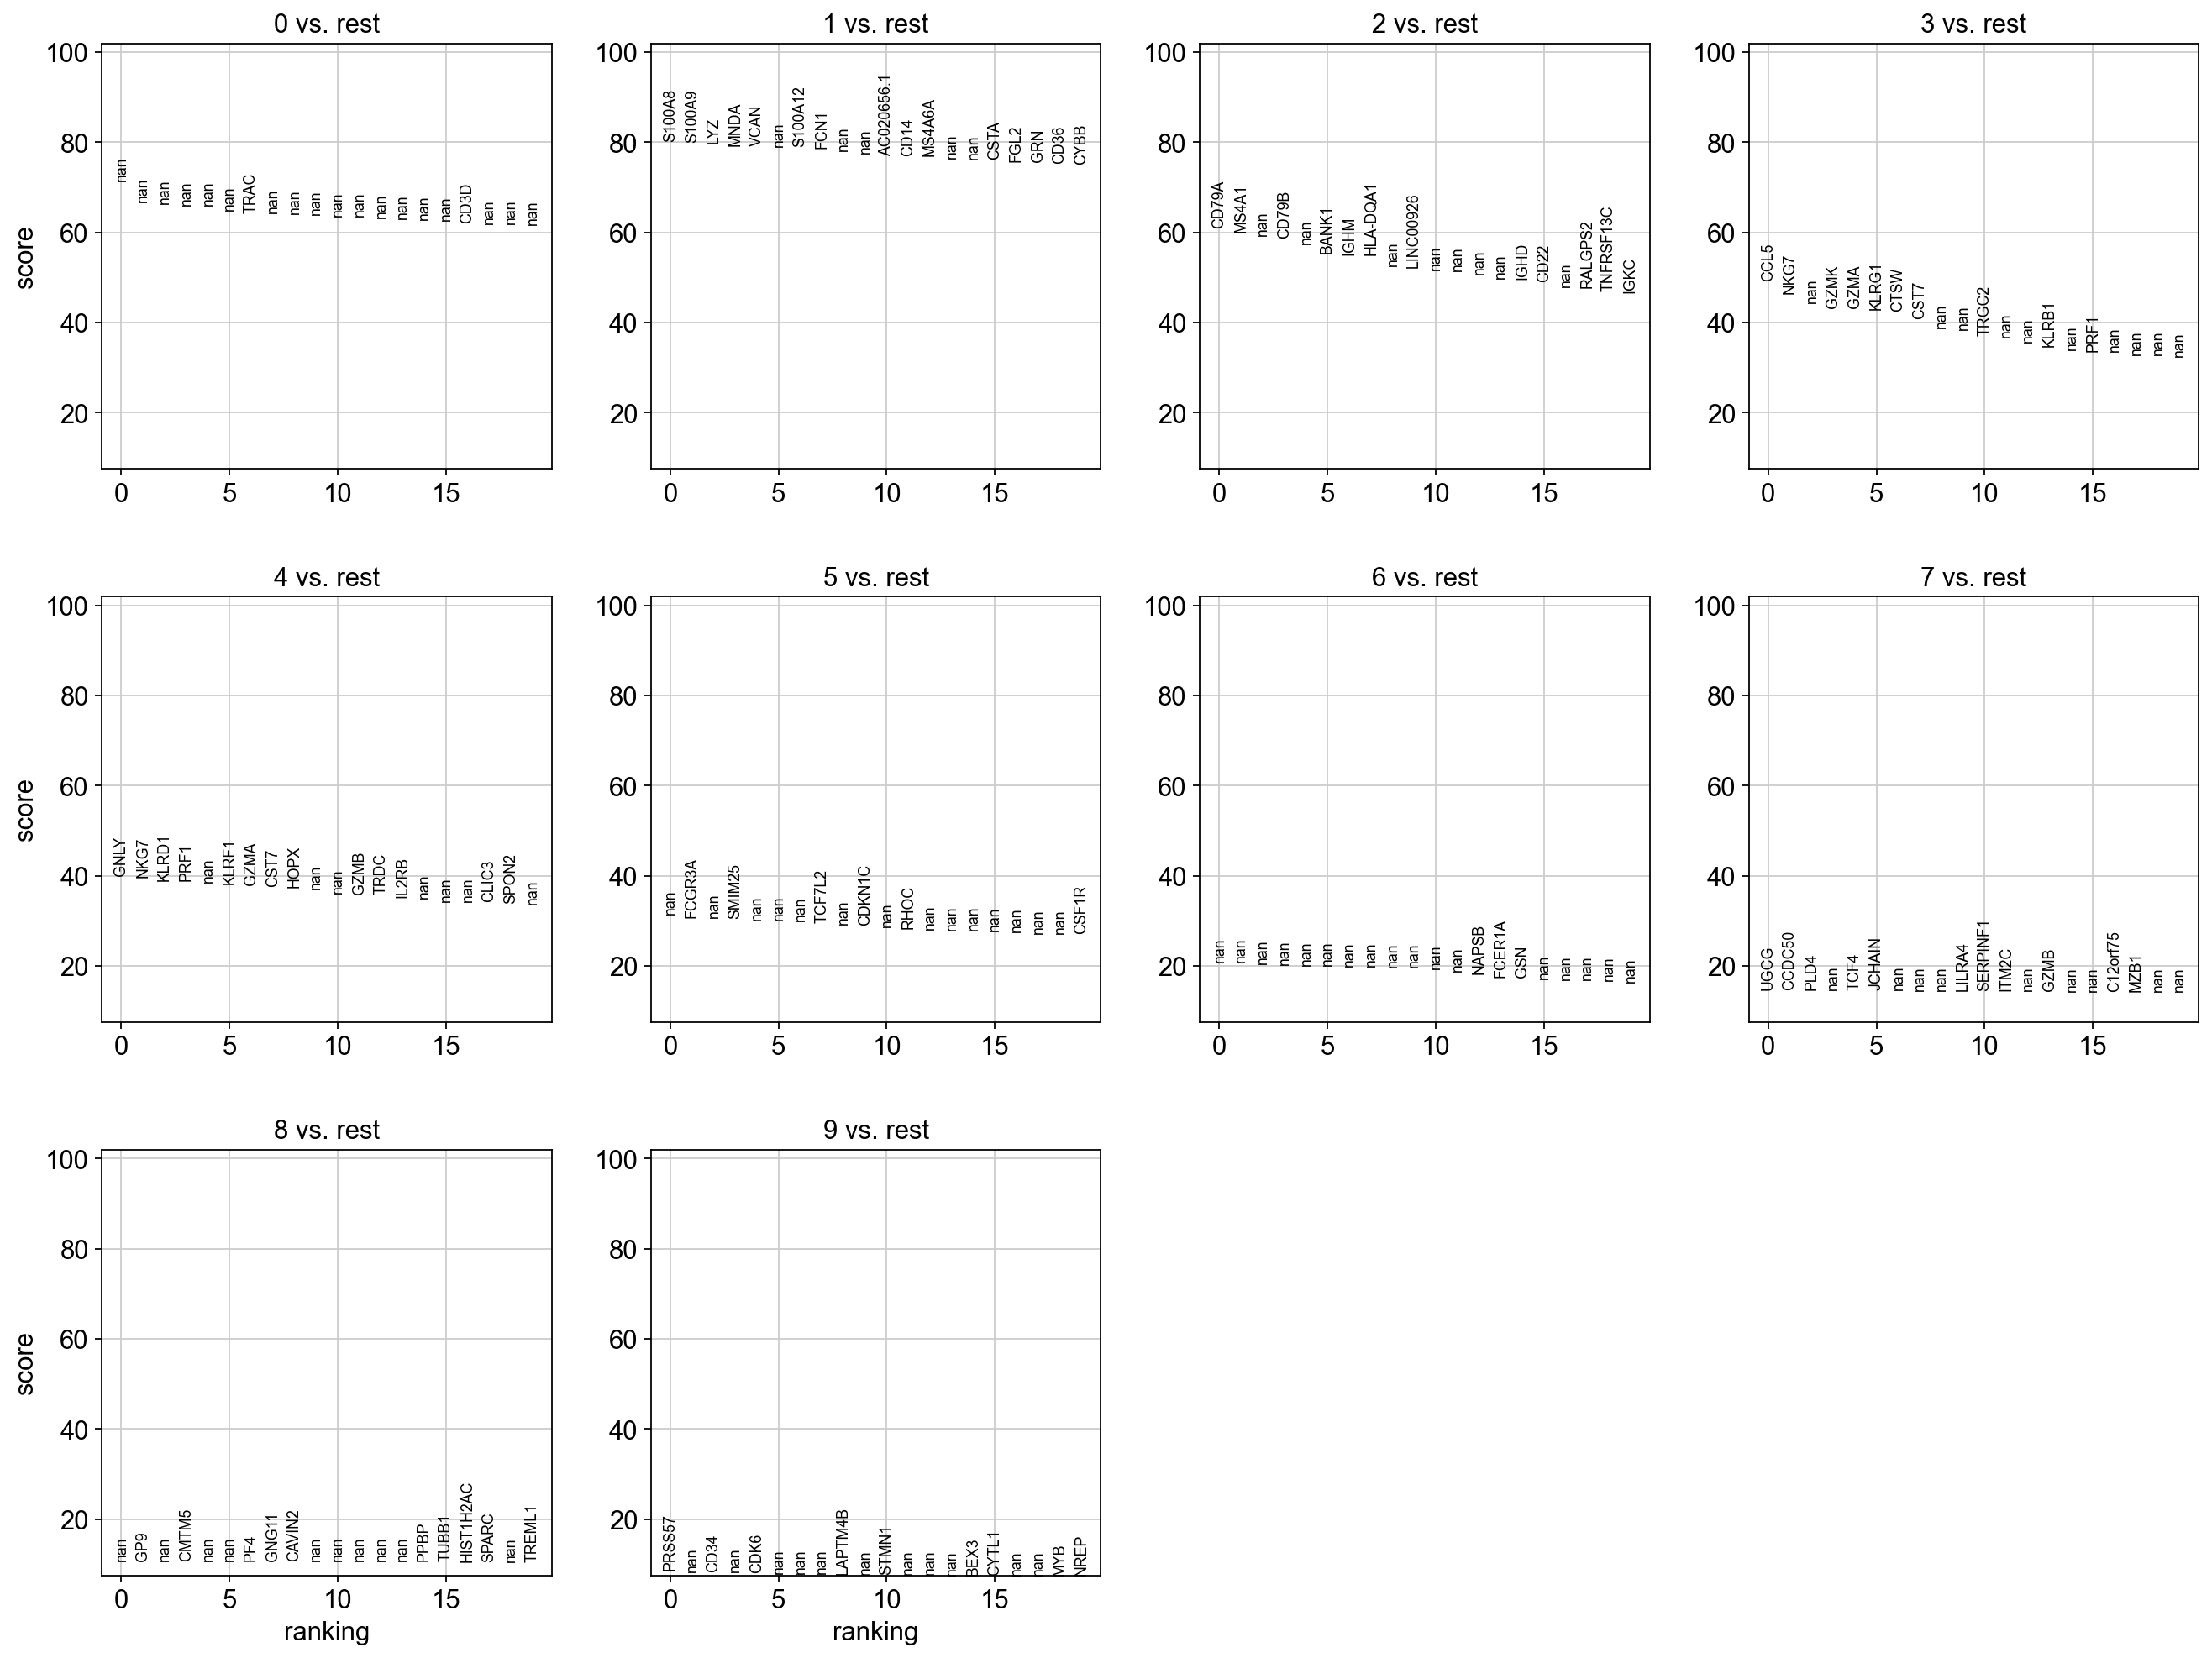

In [182]:
sc.pl.rank_genes_groups(
    adata,
    key="dea_leiden_res0_25_filtered",
    ncol=3
)

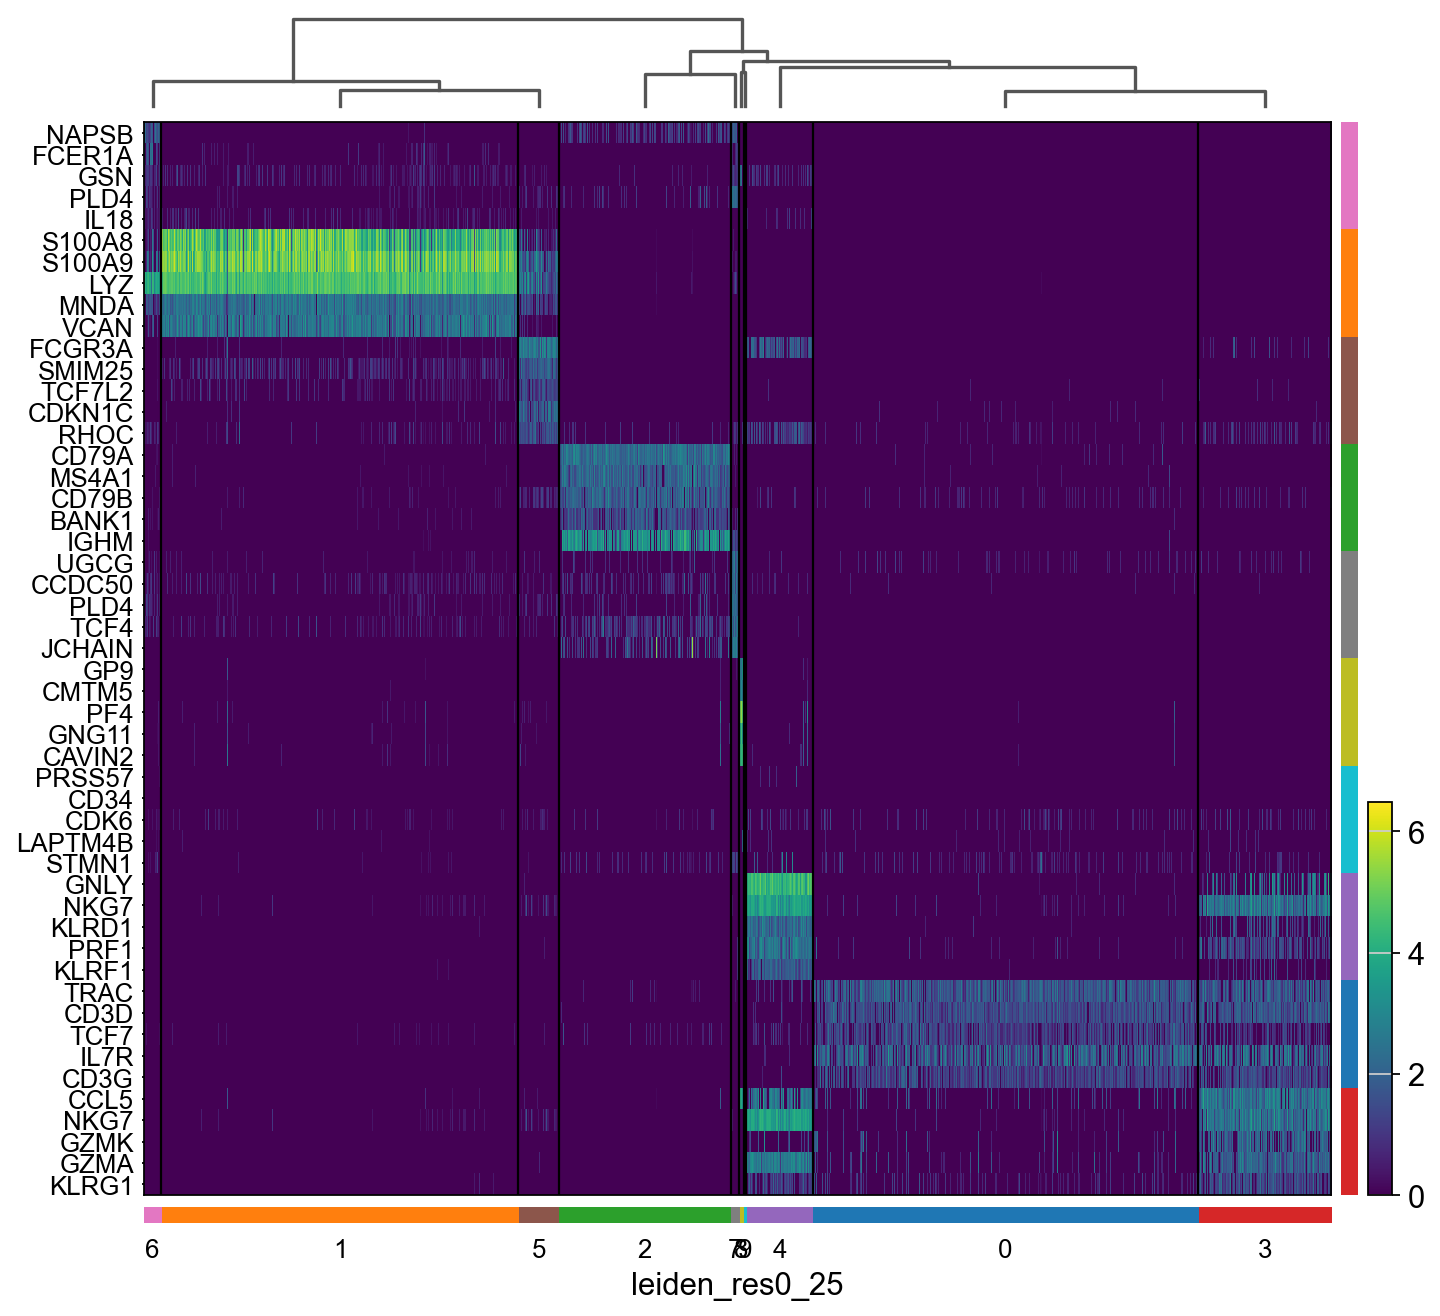

In [183]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    key="dea_leiden_res0_25_filtered",
    n_genes=5, # Gene labels are not shown when more than 50 genes are visualized. To show gene labels set `show_gene_labels=True
    show_gene_labels=True,
    swap_axes=True,
    use_raw=False,
    # vmax=3,
    # vmin=3,
    # cmap="bwr",
    dendrogram=True,
)

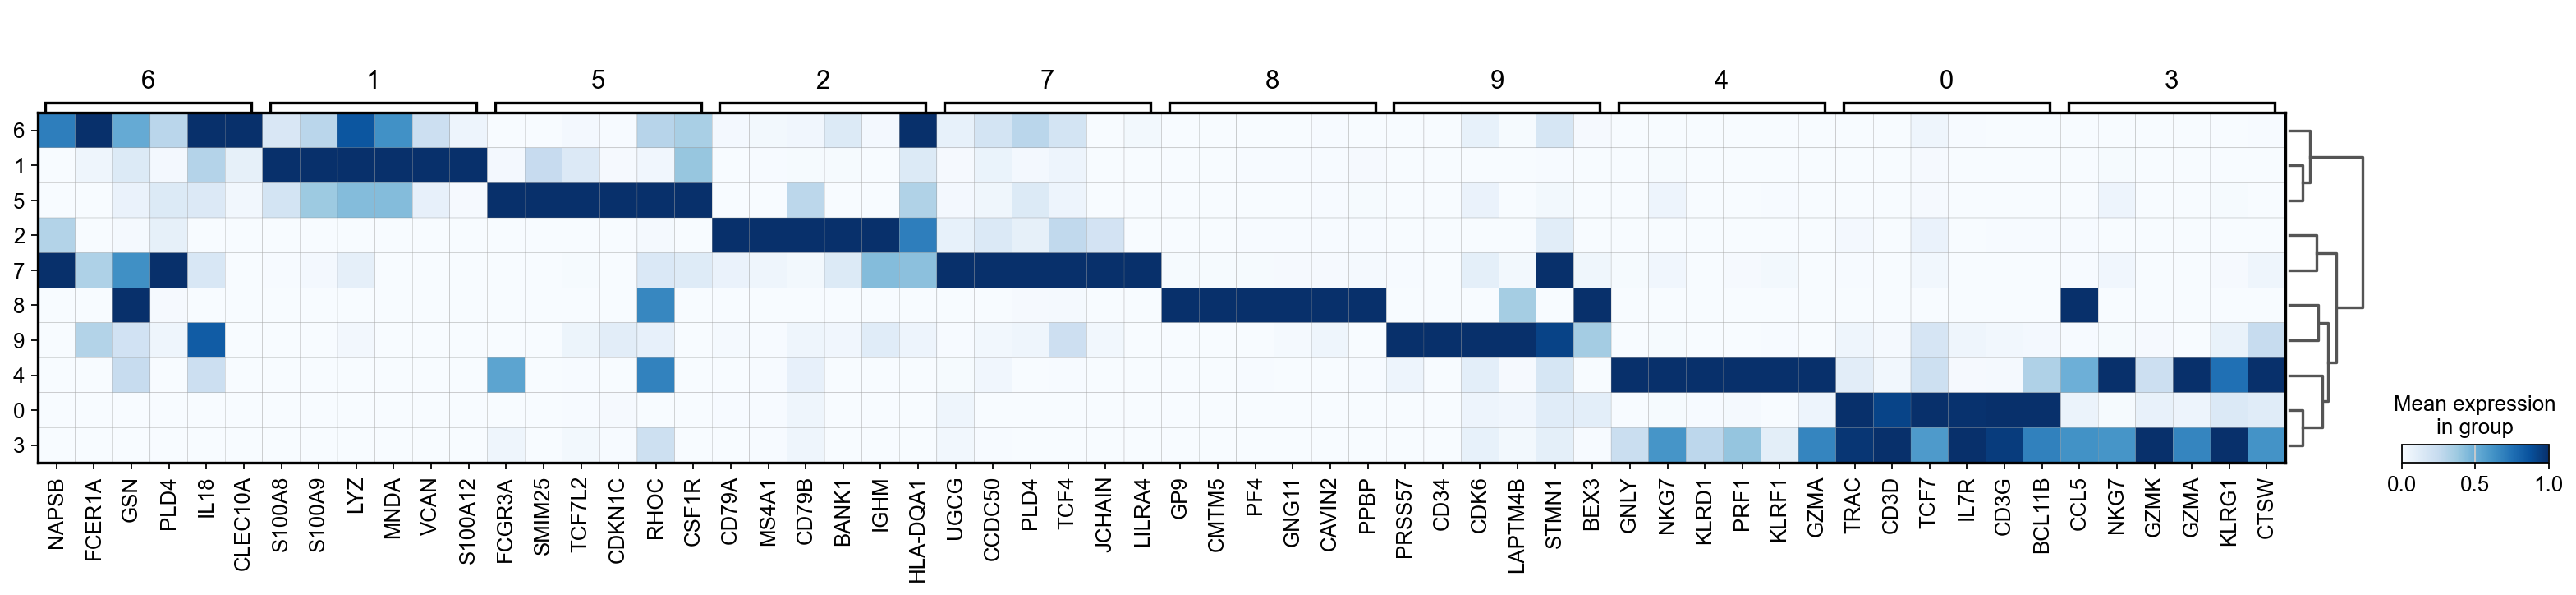

In [184]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    key="dea_leiden_res0_25_filtered",
    n_genes=6,
    use_raw=False,
    standard_scale="var",
    cmap="Blues",
)

# Automated annotation

### CellTypist

In [188]:
adata_celltypist = adata.copy()

In [189]:
adata_celltypist.X = adata.layers["celbender_counts"]  # set adata.X to raw counts

# cellTypist requires a normalisation of 10000 counts per cell, then log1p
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [190]:
# download the celltypist models
models.download_models(
    force_update=True,
    model=["Immune_All_Low.pkl", "Immune_All_High.pkl", "Healthy_COVID19_PBMC.pkl"],
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in /Users/xiliu/.celltypist/data/models
💾 Total models to download: 3
💾 Downloading model [1/3]: Immune_All_Low.pkl
💾 Downloading model [2/3]: Immune_All_High.pkl
💾 Downloading model [3/3]: Healthy_COVID19_PBMC.pkl


In [191]:
# load models
# annotate immune cell types finer annotation level (low) and coarser (high)
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")
model_PBMC = models.Model.load(model="Healthy_COVID19_PBMC.pkl") #is not a suitable model for our dataset, but a good example for the tutorial

In [77]:
display(model_high.cell_types)
display(model_low.cell_types)
display(model_PBMC.cell_types)

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

array(['ASDC', 'B_exhausted', 'B_immature', 'B_malignant', 'B_naive',
       'B_non-switched_memory', 'B_switched_memory', 'C1_CD16_mono',
       'CD14_mono', 'CD16_mono', 'CD4.CM', 'CD4.EM', 'CD4.IL22',
       'CD4.Naive', 'CD4.Prolif', 'CD4.Tfh', 'CD4.Th1', 'CD4.Th17',
       'CD4.Th2', 'CD8.EM', 'CD8.Naive', 'CD8.Prolif', 'CD8.TE',
       'CD83_CD14_mono', 'DC1', 'DC2', 'DC3', 'DC_prolif', 'HSC_CD38neg',
       'HSC_CD38pos', 'HSC_MK', 'HSC_erythroid', 'HSC_myeloid',
       'HSC_prolif', 'ILC1_3', 'ILC2', 'MAIT', 'Mono_prolif', 'NKT',
       'NK_16hi', 'NK_56hi', 'NK_prolif', 'Plasma_cell_IgA',
       'Plasma_cell_IgG', 'Plasma_cell_IgM', 'Plasmablast', 'Platelets',
       'RBC', 'Treg', 'gdT', 'pDC'], dtype=object)

In [196]:
celltypist_annotation(adata, adata_celltypist, model_high, "coarser")

🔬 Input data has 10214 cells and 58347 genes
🔗 Matching reference genes in the model
🧬 6239 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res1_5', 'doublet_scores', 'manual_celltype_annotation_leiden_res0_25', 'celltypist_cell_label_coarser', 'celltypist_conf_score_coarser', 'celltypist_cell_label_PBMC', 'celltypist_conf_score_PBMC'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'barcode_indices_for_latents', 'barcod

In [197]:
celltypist_annotation(adata, adata_celltypist, model_low, "fine")

🔬 Input data has 10214 cells and 58347 genes
🔗 Matching reference genes in the model
🧬 6239 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res1_5', 'doublet_scores', 'manual_celltype_annotation_leiden_res0_25', 'celltypist_cell_label_coarser', 'celltypist_conf_score_coarser', 'celltypist_cell_label_PBMC', 'celltypist_conf_score_PBMC', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispe

In [198]:
celltypist_annotation(adata, adata_celltypist, model_PBMC, "PBMC") # bad example

🔬 Input data has 10214 cells and 58347 genes
🔗 Matching reference genes in the model
🧬 3400 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10214 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'scDblFinder_score', 'scDblFinder_class', 'S_score', 'G2M_score', 'phase', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res1_5', 'doublet_scores', 'manual_celltype_annotation_leiden_res0_25', 'celltypist_cell_label_coarser', 'celltypist_conf_score_coarser', 'celltypist_cell_label_PBMC', 'celltypist_conf_score_PBMC', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispe

Compare the cell type annotation from celltypist (different models) with the manual annotation

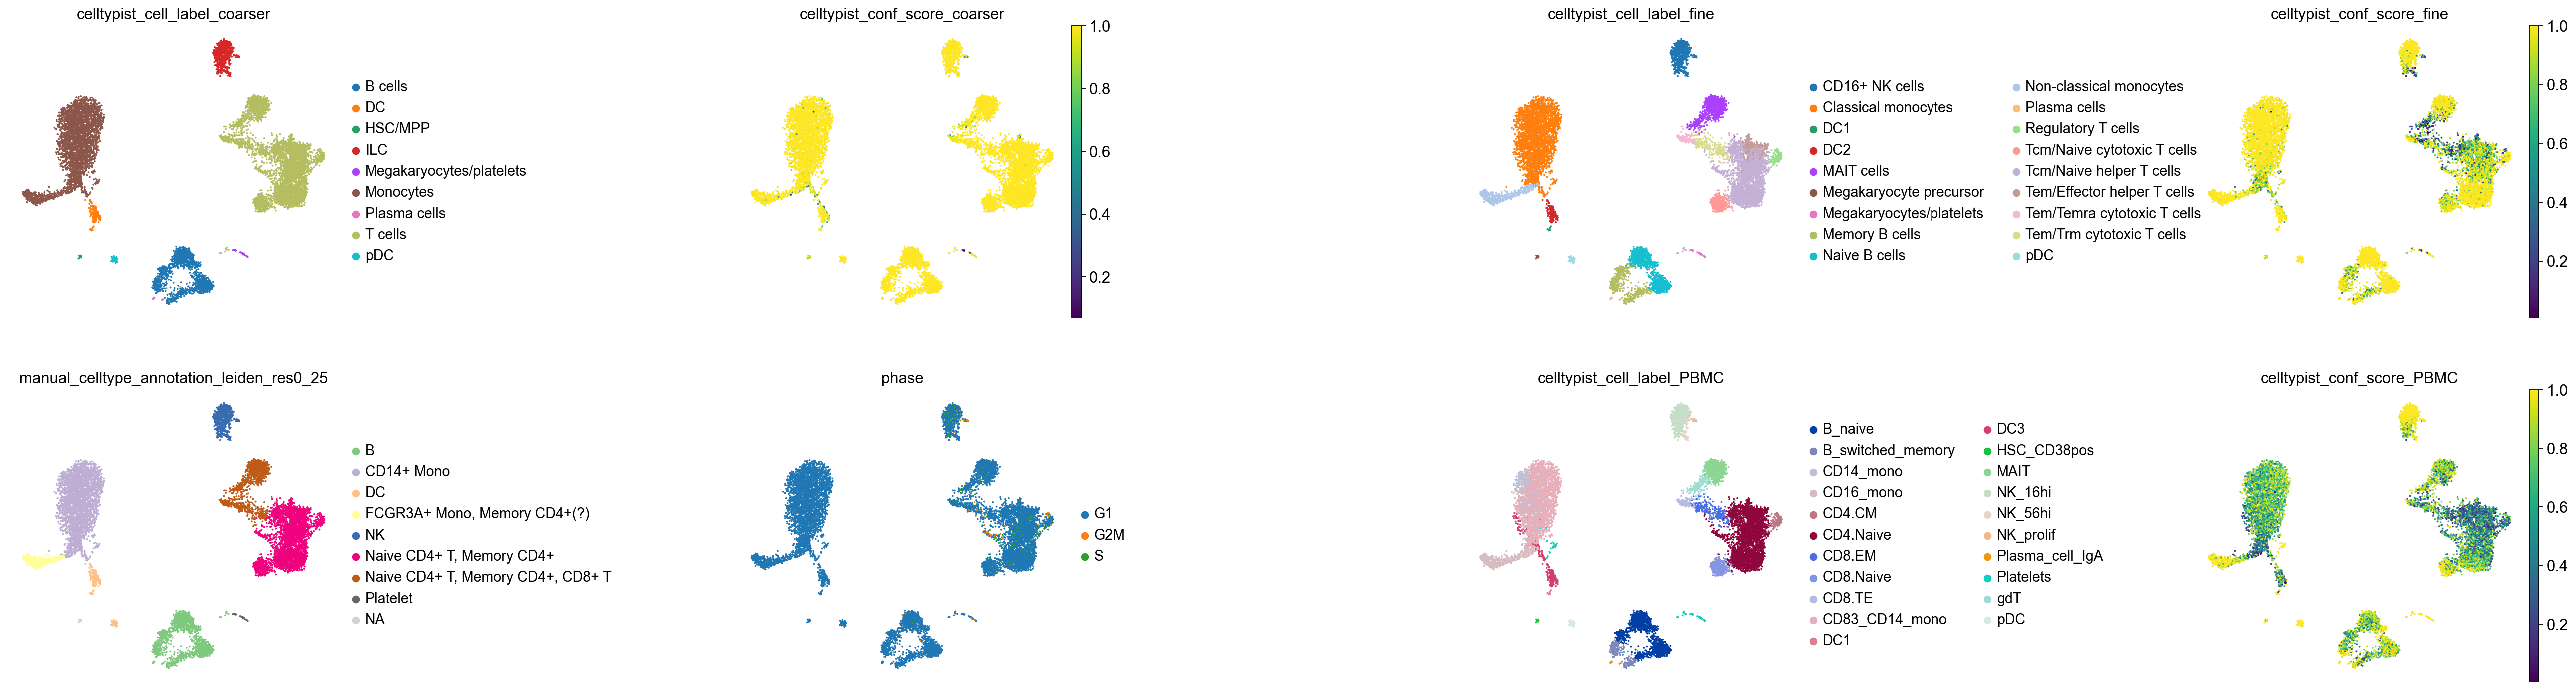

In [200]:
sc.pl.umap(
    adata,
    color=[
        "celltypist_cell_label_coarser",
        "celltypist_conf_score_coarser",
        "celltypist_cell_label_fine",
        "celltypist_conf_score_fine",
        "manual_celltype_annotation_leiden_res0_25",
        "phase",
        "celltypist_cell_label_PBMC",
        "celltypist_conf_score_PBMC",
    ],
    frameon=False,
    sort_order=False,
    wspace=1,
)

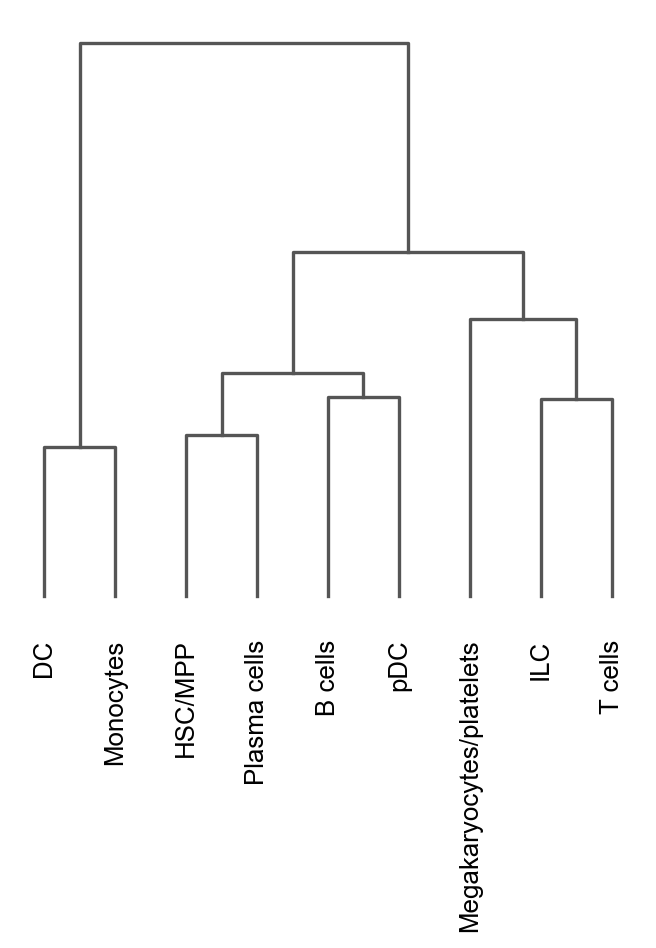

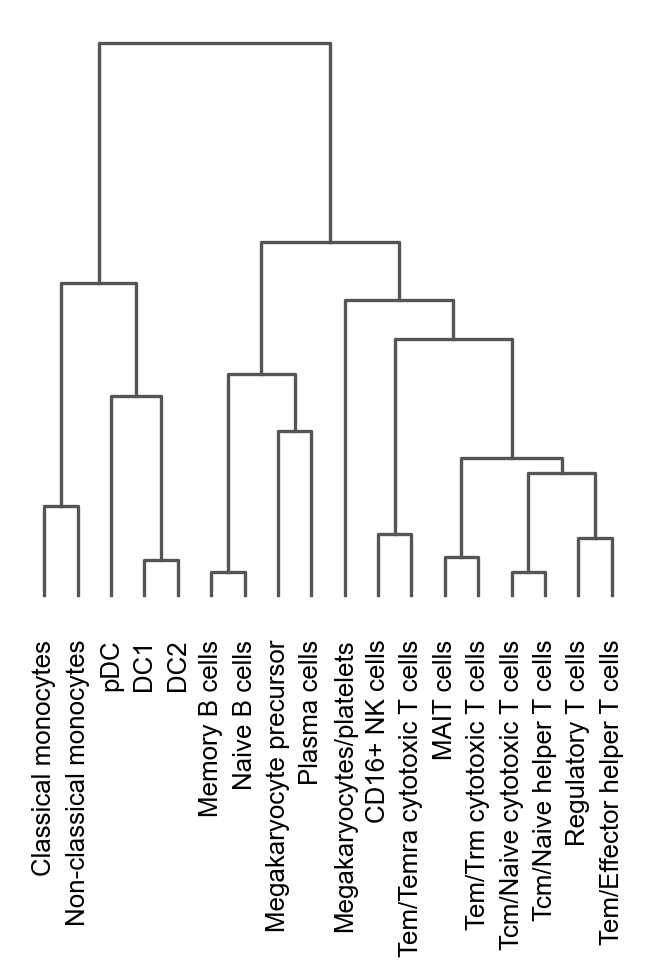

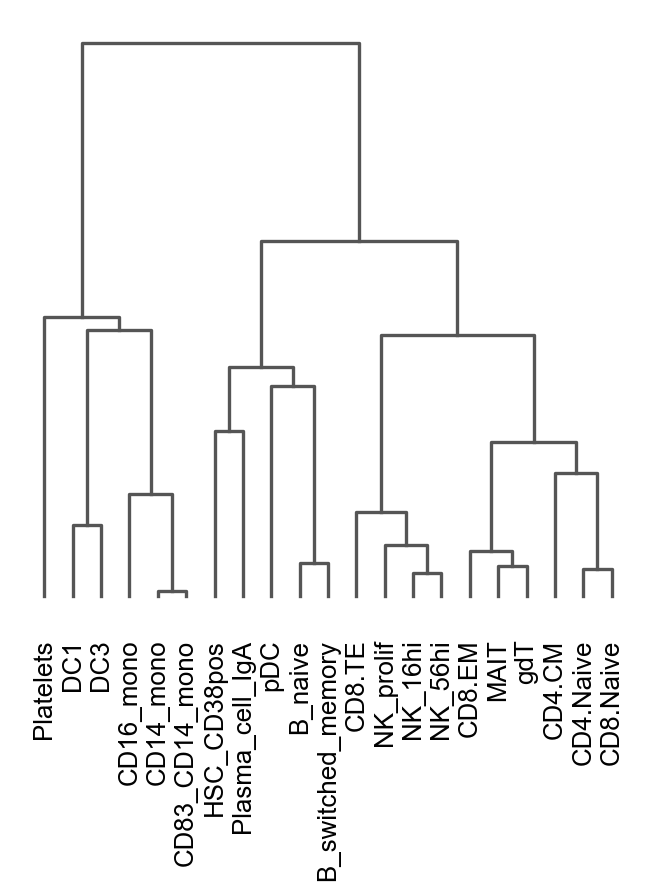

<Axes: >

In [201]:
# annotation check
# if the similar cell types are clustered together
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_coarser")
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fine")
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_PBMC")

In [83]:
adata.obs.leiden_res0_25.value_counts()

0    3316
1    3071
2    1479
3    1145
4     569
5     347
6     151
7      73
8      38
9      25
Name: leiden_res0_25, dtype: int64

In [273]:
# breakdown of a given cluster in terms of a celltypist label (here, cluster 3 and celltypist label fine)
pd.crosstab(adata.obs.leiden_res0_25, adata.obs.celltypist_cell_label_fine).loc[
    "3", :
].sort_values(ascending=False)


"""
# alternative way
adata.obs.loc[
    adata.obs.manual_celltype_annotation_leiden_res0_25 == "Naive CD4+ T, Memory CD4+, CD8+ T",
    ["manual_celltype_annotation_leiden_res0_25", "celltypist_cell_label_fine"],
].celltypist_cell_label_fine.value_counts()
"""

celltypist_cell_label_fine
MAIT cells                     770
Tem/Trm cytotoxic T cells      241
Tem/Temra cytotoxic T cells    126
Tcm/Naive helper T cells         8
CD16+ NK cells                   0
Plasma cells                     0
Tem/Effector helper T cells      0
Tcm/Naive cytotoxic T cells      0
Regulatory T cells               0
Non-classical monocytes          0
Classical monocytes              0
Naive B cells                    0
Memory B cells                   0
Megakaryocytes/platelets         0
Megakaryocyte precursor          0
DC2                              0
DC1                              0
pDC                              0
Name: 3, dtype: int64

###### Globally, the celltypist annotation is very similar to the manual annotation. The main differences are the following:
###### Celltypist agrees on "T cells", but separate into MAIT, Tem/Trm, Tem/Temra and Tcm T cells. But pay attention, in the more precise annotation, some are not so sure with a low/very low score.

In [202]:
# breakdown of a given cluster in terms of a celltypist label (here, cluster 3 and celltypist label fine)
pd.crosstab(adata.obs.leiden_res0_25, adata.obs.celltypist_cell_label_coarser).loc[
    "3", :
].sort_values(ascending=False)

celltypist_cell_label_coarser
T cells                     1145
B cells                        0
DC                             0
HSC/MPP                        0
ILC                            0
Megakaryocytes/platelets       0
Monocytes                      0
Plasma cells                   0
pDC                            0
Name: 3, dtype: int64

### Annotation by mapping to a reference : interesting method but need GPU, so give up for now

###### Note that scArches does not run, or runs very slowly if you do not have access to a GPU. You might therefore need to run this part of the notebook from a computing cluster/server.

Optional: Method in best practices of Theis lab

###### have to use gencode ID, when you use ensembl ID, we will find he duplicated gene name, and it will bug scArches

In [224]:
#adata_to_map = adata.copy()
adata_to_map = sc.read_h5ad(input_h5ad)

# keep only the raw count layer
for layer in list(adata_to_map.layers.keys()):
    if layer != "celbender_counts":
        del adata_to_map.layers[layer]
adata_to_map.X = adata_to_map.layers["celbender_counts"]

# rename celbender_counts layer to counts
adata_to_map.layers["counts"] = adata_to_map.layers.pop("celbender_counts")

In [235]:
# find the missing genes in the reference model but not in our data
missing_genes = [
    gene_id
    for gene_id in reference_model_features.index
    if gene_id not in adata_to_map.var.index
]

print("Total number of missing genes:", len(missing_genes))

Total number of missing genes: 109


In [236]:
# add the miss genes in a new adata and set their counts to 0,
# as it seems like these genes were not detected in our data.
missing_gene_adata = sc.AnnData(
    X=csr_matrix(np.zeros(shape=(adata.n_obs, len(missing_genes))), dtype="float32"),
    obs=adata.obs.iloc[:, :1],
    var=reference_model_features.loc[missing_genes, :],
)
missing_gene_adata.layers["counts"] = missing_gene_adata.X

In [237]:
# Concatenate our original adata to the missing genes adata.
# To make sure we can do this concatenation without errors, we’ll remove the PCA matrix from varm
if "PCs" in adata_to_map.varm.keys():
    del adata_to_map.varm["PCs"]

In [238]:
adata_to_map_augmented = sc.concat(
    [adata_to_map, missing_gene_adata],
    axis=1,
    join="outer",
    index_unique=None,
    merge="unique",
)

In [240]:
# Remove duplicated index values: Reindexing only valid with uniquely valued Index objects
#NB: here we lost information about the duplicated genes
duplicated_index = adata_to_map_augmented.var.index.duplicated()
adata_to_map_augmented = adata_to_map_augmented[:, ~duplicated_index].copy()

# subset to the genes used in the model and order correctly
adata_to_map_augmented = adata_to_map_augmented[
    :, reference_model_features.index
].copy()

In [241]:
# Check if our adata gene names correspond exactly to the required gene order
(adata_to_map_augmented.var.index == reference_model_features.index).all()

True

In [ ]:
# set the gene indices back to gene names for easy interpretation
adata_to_map_augmented.var["gene_ids"] = adata_to_map_augmented.var.index
adata_to_map_augmented.var.set_index("gene_names", inplace=True)

In [ ]:
# this reference model used adata.obs[‘batch’] as our batch variable.
#We will therefore check that we have this set to one value for our entire sample
adata_to_map_augmented.obs.batch.unique()

In [6]:
"""
# loading model.pt
import urllib.request

if not os.path.exists("./reference_model"):
    os.mkdir("./reference_model")
elif not os.path.exists("./reference_model/model.pt"):
    urllib.request.urlretrieve(
        "https://figshare.com/ndownloader/files/41436648",
        filename="reference_model/model.pt",
    )
"""

In [ ]:
# Option: run the model is required the batch information in adata.obs
# todo, if you have already batch information in adata.obs, you can skip this step
adata_to_map_augmented.obs["batch"] = "1"

# passing model on the adata which we want to map
scarches_model = sca.models.SCVI.load_query_data(
    adata=adata_to_map_augmented,
    reference_model="./reference_model",
    freeze_dropout=True,
)

In [ ]:
# update the reference model then embed our own data (the “query”)
#in the same latent space as the reference.
#This requires training on our query data using scArches
scarches_model.train(max_epochs=500, plan_kwargs=dict(weight_decay=0.0))

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["IGHD", "IGHM", "PRDM1"],
    vmin=0,
    vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
    sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
    frameon=False,
    cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
)

In [ ]:
ref_emb = sc.read(
    filename="reference_embedding.h5ad",
    backup_url="https://figshare.com/ndownloader/files/41376264",
)

In [ ]:
ref_emb.obs["reference_or_query"] = "reference"

In [ ]:
adata_emb = sc.AnnData(X=adata.obsm["X_scVI"], obs=adata.obs)

In [ ]:
adata_emb.obs["reference_or_query"] = "query"

In [ ]:
emb_ref_query = sc.concat(
    [ref_emb, adata_emb],
    axis=0,
    join="outer",
    index_unique=None,
    merge="unique",
)

In [ ]:
sc.pp.neighbors(emb_ref_query)
sc.tl.umap(emb_ref_query)

In [ ]:
sc.pl.umap(
    emb_ref_query,
    color=["reference_or_query"],
    sort_order=False,
    frameon=False,
)

In [ ]:
sc.set_figure_params(figsize=(8, 8))

In [ ]:
sc.pl.umap(
    emb_ref_query,
    color=["cell_type"],
    sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)

In [ ]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=ref_emb,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=15,
)

In [ ]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_emb,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="cell_type",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=ref_emb.obs,
)

In [ ]:
adata_emb.obs["transf_cell_type"] = labels.loc[adata_emb.obs.index, "cell_type"]
adata_emb.obs["transf_cell_type_unc"] = uncert.loc[adata_emb.obs.index, "cell_type"]

In [ ]:
adata.obs.loc[adata_emb.obs.index, "transf_cell_type"] = adata_emb.obs[
    "transf_cell_type"
]
adata.obs.loc[adata_emb.obs.index, "transf_cell_type_unc"] = adata_emb.obs[
    "transf_cell_type_unc"
]

In [ ]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(adata, color="transf_cell_type", frameon=False)
sc.pl.umap(adata, color="transf_cell_type_unc", frameon=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ct_order = (
    adata.obs.groupby("transf_cell_type")
    .agg({"transf_cell_type_unc": "median"})
    .sort_values(by="transf_cell_type_unc", ascending=False)
)
sns.boxplot(
    adata.obs,
    x="transf_cell_type",
    y="transf_cell_type_unc",
    color="grey",
    ax=ax,
    order=ct_order.index,
)
ax.tick_params(rotation=90, axis="x")

In [ ]:
adata.obs["transf_cell_type_certain"] = adata.obs.transf_cell_type.tolist()
adata.obs.loc[
    adata.obs.transf_cell_type_unc > 0.2, "transf_cell_type_certain"
] = "Unknown"

In [ ]:
sc.pl.umap(adata, color=["transf_cell_type_certain", ], frameon=False)
sc.pl.umap(adata, color="transf_cell_type_certain", groups="Unknown")

In [ ]:
cell_types_to_check = [
    "CD14+ Mono",
    "cDC2",
    "NK",
    "B1 B",
    "CD4+ T activated",
    "T naive",
    "MK/E prog",
]

In [ ]:
sc.pl.dotplot(
    adata,
    var_names={
        ct: marker_genes_in_data[ct] for ct in cell_types_to_check
    },  # gene names grouped by cell type in a dictionary
    groupby="transf_cell_type_certain",
    standard_scale="var",  # normalize gene scores from 0 to 1
)

In [ ]:
sc.pl.umap(
    adata, color=["transf_cell_type_unc", "transf_cell_type_certain"], frameon=False
)

In [ ]:
adata.write("./annotation_adata_out.h5ad")

###### duplicate ensemble id phenomena

In [99]:
duplicate_gene_ids = adata.var[adata.var.duplicated(subset='gene_id')]['gene_id']
print(duplicate_gene_ids)

AL954722.1-1       ENSG00000228572
PLCXD1-1           ENSG00000182378
GTPBP6-1           ENSG00000178605
LINC00685-1        ENSG00000226179
PPP2R3B-1          ENSG00000167393
AL732314.6-1       ENSG00000281849
Metazoa_SRP-169    ENSG00000275287
AL732314.4-1       ENSG00000280767
FABP5P13-1         ENSG00000234958
KRT18P53-1         ENSG00000229232
SHOX-1             ENSG00000185960
AL672277.1-1       ENSG00000237531
RPL14P5-1          ENSG00000225661
CRLF2-1            ENSG00000205755
CSF2RA-1           ENSG00000198223
MIR3690-1          ENSG00000265658
RNA5SP498-1        ENSG00000223274
IL3RA-1            ENSG00000185291
SLC25A6-1          ENSG00000169100
LINC00106-1        ENSG00000236871
ASMTL-AS1-1        ENSG00000236017
ASMTL-1            ENSG00000169093
P2RY8-1            ENSG00000182162
AKAP17A-1          ENSG00000197976
ASMT-1             ENSG00000196433
AL683807.1-1       ENSG00000223511
AL683807.2-1       ENSG00000234622
DHRSX-1            ENSG00000169084
DHRSX-IT1-1        E

In [130]:
import re
gene_indices = adata.var.loc[
    adata.var.index.str.contains(r"AL732314\.6(-\d+)?$"), "gene_id"
]
print(gene_indices)

AL732314.6            ENSG00000281849.3
AL732314.6-1    ENSG00000281849.3_PAR_Y
Name: gene_id, dtype: object


In [133]:
gene_indices = adata.var.loc[
    adata.var.index.str.contains(r"Metazoa_SRP(-\d+)?$"), "gene_id"
]
print(gene_indices)

Metazoa_SRP              ENSG00000277958.1
Metazoa_SRP-1            ENSG00000276493.1
Metazoa_SRP-2            ENSG00000277617.1
Metazoa_SRP-3            ENSG00000276645.1
Metazoa_SRP-4            ENSG00000278702.1
                            ...           
Metazoa_SRP-165          ENSG00000275975.1
Metazoa_SRP-166          ENSG00000277900.1
Metazoa_SRP-167          ENSG00000275070.1
Metazoa_SRP-168          ENSG00000278724.1
Metazoa_SRP-169    ENSG00000275287.5_PAR_Y
Name: gene_id, Length: 170, dtype: object


scArches using a customer reference

In [239]:
# create a new adata object with the raw counts
adata_scArches = adata.raw.to_adata()
adata_scArches = remove_sparsity(adata_scArches) # remove sparsity, and keep only obs and var

In [246]:
# Create the artificial batch and study information for the test data
adata_scArches.obs["batch"] = "1"
adata_scArches.obs["study"] = "pbmc10k_v3"

In [248]:
condition_key = "study"
cell_type_key = "celltypist_cell_label_coarser"
target_conditions = ["pbmc10k_v3"]

In [252]:
# Make sure that count data is in the adata.X
# count data in adata.X is necessary when using “nb” or “zinb” loss
source_adata = adata_scArches[
    adata_scArches.obs[condition_key].isin(target_conditions)
].copy()

###### Create SCVI model and train it on reference dataset

In [256]:
# Preprocess reference dataset
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu" # set the platform to use CPU instead of GPU
sca.models.SCVI.setup_anndata(source_adata, batch_key=condition_key)

In [260]:
# Create the SCVI model instance with ZINB loss as default
# Insert “gene_likelihood=’nb’,” to change the reconstruction loss to NB loss
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)
print(vae)

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [263]:
vae.train()

TypeError: `devices` selected with `CPUAccelerator` should be an int > 0.

### Construct a better annotation by comparing the results from different methods
Manual comparison with several methods' results, then improve the annotation.

Alternatively, scTriangulate can handle the improvement from several annotations (https://github.com/frankligy/scTriangulate)

###### Here, just an example of combining the annotation to a better one

In [289]:
# follow cellTypist annotation
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "B cells", "better_annotation"] = "B cells"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "DC", "better_annotation"] = "DC"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "HSC/MPP", "better_annotation"] = "Hematopoietic precursor cell"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "Monocytes", "better_annotation"] = "Monocytes"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "Plasma cells", "better_annotation"] = "Plasma cells"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "pDC", "better_annotation"] = "pDC"
adata.obs.loc[adata.obs.celltypist_cell_label_coarser == "T cells", "better_annotation"] = "T cells"

# follow manual annotation
adata.obs.loc[adata.obs.manual_celltype_annotation_leiden_res0_25 == "NK", "better_annotation"] = "NK"
adata.obs.loc[adata.obs.manual_celltype_annotation_leiden_res0_25 == "Platelet", "better_annotation"] = "Platelets"

... storing 'better_annotation' as categorical


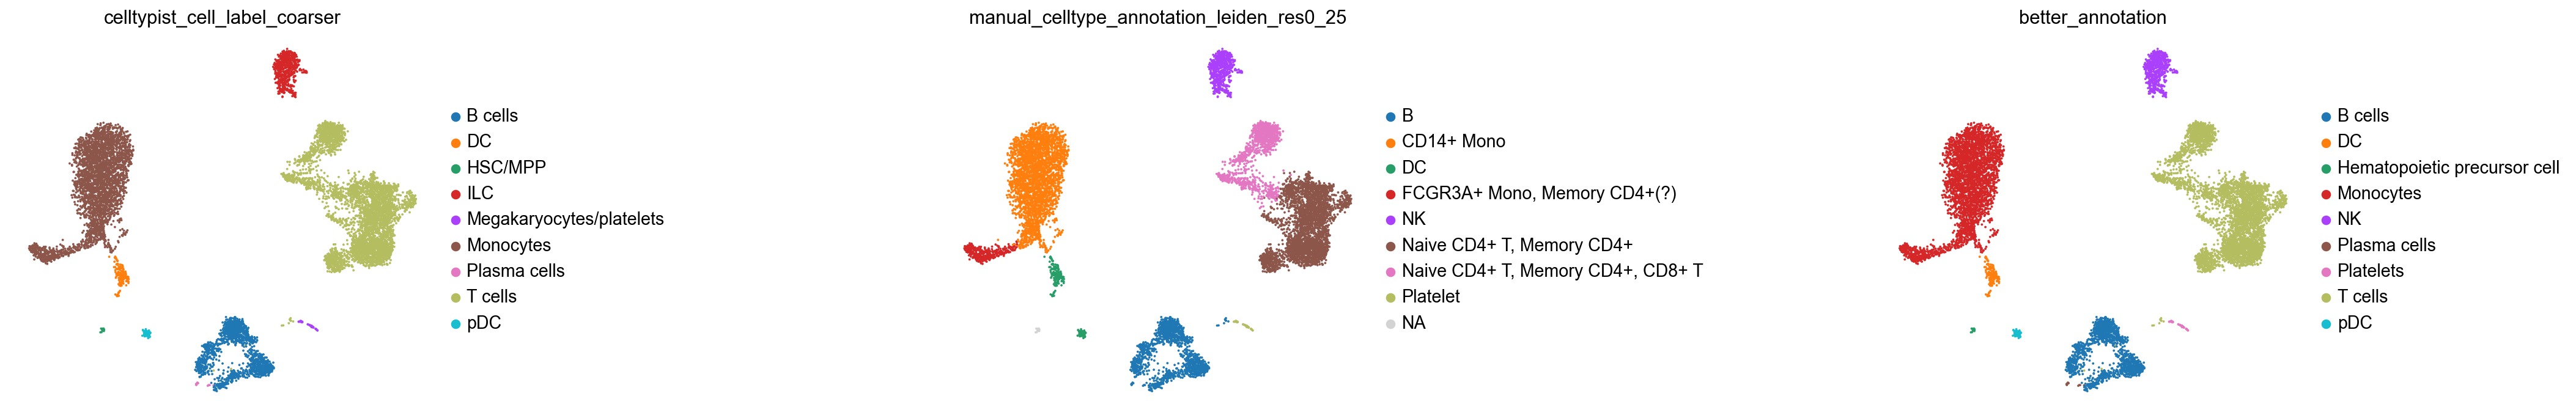

In [292]:
sc.pl.umap(
    adata,
    color=[
        "celltypist_cell_label_coarser",
        "manual_celltype_annotation_leiden_res0_25",
        "better_annotation",
    ],
    frameon=False,
    sort_order=False,
    wspace=1,
)

### Annotation for CellxGene style
CellxGene requires a cell types to be in a column named cell_type_ontology_term_id and to follow the official conventions of Cell Ontology (https://www.ebi.ac.uk/ols/ontologies/cl), for example, T-Cell would be "CL:0000084"

In [295]:
adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "B cells", "better_annotation"
] = "B cells"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "DC", "better_annotation"
] = "DC"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "HSC/MPP", "better_annotation"
] = "Hematopoietic precursor cell"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "Monocytes", "better_annotation"
] = "Monocytes"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "Plasma cells", "better_annotation"
] = "Plasma cells"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "pDC", "better_annotation"
] = "pDC"

adata.obs.loc[
    adata.obs.celltypist_cell_label_coarser == "T cells", "better_annotation"
] = "T cells"

# follow manual annotation
adata.obs.loc[
    adata.obs.manual_celltype_annotation_leiden_res0_25 == "NK", "better_annotation"
] = "NK"

adata.obs.loc[
    adata.obs.manual_celltype_annotation_leiden_res0_25 == "Platelet",
    "better_annotation",
] = "Platelets"

In [296]:
adata.obs.better_annotation.value_counts()

T cells                         4473
Monocytes                       3418
B cells                         1453
NK                               569
DC                               151
pDC                               73
Platelets                         38
Hematopoietic precursor cell      25
Plasma cells                      14
Name: better_annotation, dtype: int64

In [300]:
celltype_to_cell_ont = {
    "T cells": "CL:0000084",
    "Monocytes": "CL:0000576",
    "B cells": "CL:0000236",
    "NK": "CL:0000623",
    "DC": "CL:0000451",
    "pDC": "CL:0001058",
    "Platelets": "CL:0000233",
    "Hematopoietic precursor cell": "CL:0008001",
    "Plasma cells": "CL:0000786",
}

adata.obs["cell_type_ontology_term_id"] = adata.obs["better_annotation"].map(celltype_to_cell_ont)

In [301]:
adata.obs

background_fraction  cell_probability     cell_size  \
CAGAGCCTCTTCGATT             0.001418          0.999955  17112.318359   
TACATTCTCCGTAGTA             0.001654          0.999955  17020.669922   
ATCACGAAGGGACACT             0.001414          0.999955  16725.431641   
ATCTTCATCCCGAATA             0.001732          0.999955  16453.822266   
TGTTACTTCTACAGGT             0.001568          0.999955  16203.316406   
...                               ...               ...           ...   
CCTAAGACAGCGAACA             0.293777          0.999984   2954.608154   
CTCCTTTGTACAGTTC             0.264426          0.999971   2967.668945   
CCTACGTAGCACCTGC             0.276518          0.999998   2711.298096   
GAGGGATAGTAAACGT             0.275862          0.999977   2838.524658   
TATTGGGGTCATACCA             0.272930          0.999983   2764.336182   

                  droplet_efficiency  n_genes_by_counts  \
CAGAGCCTCTTCGATT            2.482191               4812   
TACATTCTCCGTAGTA            2.468767               5152   
ATCACGAAGGGACACT            2.459050               4174   
ATCTTCATCCCGAATA            2.411249               6309   
TGTTACTTCTACAGGT            2.377210               5381   
...                              ...                ...   
CCTAAGACAGCGAACA            0.608236                522   
CTCCTTTGTACAGTTC            0.599723                515   
CCTACGTAGCACCTGC            0.675461                614   
GAGGGATAGTAAACGT            0.632272                532   
TATTGGGGTCATACCA            0.644366                605   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
CAGAGCCTCTTCGATT                 8.479076       40838.0           10.617393   
TACATTCTCCGTAGTA                 8.547334       40432.0           10.607402   
ATCACGAAGGGACACT                 8.336870       39553.0           10.585422   
ATCTTCATCCCGAATA                 8.749891       38049.0           10.546656   
TGTTACTTCTACAGGT                 8.590815       36933.0           10.516888   
...                                   ...           ...                 ...   
CCTAAGACAGCGAACA                 6.259581         976.0            6.884487   
CTCCTTTGTACAGTTC                 6.246107        1007.0            6.915723   
CCTACGTAGCACCTGC                 6.421622         989.0            6.897705   
GAGGGATAGTAAACGT                 6.278521         987.0            6.895683   
TATTGGGGTCATACCA                 6.406880         975.0            6.883463   

                  pct_counts_in_top_20_genes  total_counts_mt  ...  \
CAGAGCCTCTTCGATT                   49.248249           4445.0  ...   
TACATTCTCCGTAGTA                   39.490997           3020.0  ...   
ATCACGAAGGGACACT                   65.992466           1273.0  ...   
ATCTTCATCCCGAATA                   18.662777           3729.0  ...   
TGTTACTTCTACAGGT                   38.142041           2562.0  ...   
...                                      ...              ...  ...   
CCTAAGACAGCGAACA                   42.315574            118.0  ...   
CTCCTTTGTACAGTTC                   43.594836             71.0  ...   
CCTACGTAGCACCTGC                   29.120324             92.0  ...   
GAGGGATAGTAAACGT                   37.284701             89.0  ...   
TATTGGGGTCATACCA                   30.051282             68.0  ...   

                  doublet_scores  manual_celltype_annotation_leiden_res0_25  \
CAGAGCCTCTTCGATT             0.5                                          B   
TACATTCTCCGTAGTA             0.5                                          B   
ATCACGAAGGGACACT             0.5                                          B   
ATCTTCATCCCGAATA             0.5                                 CD14+ Mono   
TGTTACTTCTACAGGT             0.5                                         DC   
...                          ...                                        ...   
CCTAAGACAGCGAACA             0.5                  Naive CD4+ T, Memory CD4+   
CTCCTTTGTA

# Write output to h5ad

In [303]:
# Identify non-string objects in adata.uns by checking the type of each object. 
#if the type is not str, then convert them to strings
for key in adata.uns:
    if not isinstance(adata.uns[key], str):
        adata.uns[key] = str(adata.uns[key])

PATH_TO_OUTPUT = "../scAtlas/tmp/10k_pbmc_v3_out_annotation.h5ad"
adata.write_h5ad(PATH_TO_OUTPUT)